------
**You cannot apply any changes to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------


# Practical 2: Representing Sentences with Neural Models

In this second practical, we will train neural network models to obtain sentence representations. We can then use these sentence representations for a downstream task such as sentiment classification.

In this notebook, we will help you to develop models for your experiments. But this time, next to completing the notebook, **you are expected to write a four-page scientific report with your findings**. Please still submit the notebook together with your scientific report so that we can reproduce your experiments. (Note: if you find it useful, you can split this notebook into multiple notebooks. If you do so, keep it mind that it should be possible for your TAs to reproduce the entire content of the notebooks without having to ask for clarifications or to copy and paste functions from one sub-notebook to another.) Make sure your code corresponds to the description you give in the report; we will deduct points if this is not the case. **Make sure you run all your code before submitting the notebook, and do not leave unnecessary print statements / cells in your notebook that are not intended for the grader.**

**Important!** The main purpose of this lab is for you to learn how to answer research questions by experimenting and then writing a scientific report.
So you will be *judged by the quality of your report* but will lose points if your experiments are not reproducible.
You can find the requirements for the report at the end of this notebook.


### Data set
We will use the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/) (SST), which provides sentences, their binary tree structure, and fine-grained sentiment scores.
This dataset is different from the one we used in the first practical.
In Practical 1, a review consisted of several sentences, and we had one sentiment score for the whole review. Now, a review consists of a single sentence, and we have a sentiment score for each node in the binary tree that makes up the sentence, including the root node (i.e., we still have an overall sentiment score for the entire review). We will look at an example below.

In the first part of this practical we will only make use of the sentence tokens whereas in the second part we will also exploit the tree structure that is provided by the SST.

We will cover the following approaches:

- Bag-of-words (BOW)
- Continuous bag-of-words (CBOW)
- Deep continuous bag-of-words (Deep CBOW)
- LSTM
- Tree-LSTM


## Preparing the data

Let's first download the data set and take a look.

In [1]:
# Run if libraries not installed
# %pip install re
# %pip install random
# %pip install time
# %pip install math
# %pip install nltk
# %pip install numpy
# %pip install matplotlib

In [2]:
import re
import random
import time
import math
import numpy as np
import nltk
import matplotlib.pyplot as plt
plt.style.use('default')

In [ ]:
#! brew install wget

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:720d4fb1164e600f787d656019a8e46314dc38e1885f4a8df809c180acf5e7b3
######################################################################### 100.0%                             64.3%
==> Pouring portable-ruby-3.3.6.el_capitan.bottle.tar.gz
==> Auto-updated Homebrew!
Updated 5 taps (homebrew/services, mongodb/brew, symfony-cli/tap, homebrew/core and homebrew/cask).
==> New Formulae
action-docs                gplugin                    python-freethreading
ansible-builder            havn                       recc
ansible@10                 hawkeye                    rip2
azqr                       icu4c@74                   rust-script
beautysh                   icu4c@76                   screenpipe
bibtex-tidy      

In [3]:
# ! brew install wget -> run if wget not installed
!wget http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
!unzip trainDevTestTrees_PTB.zip

--2024-12-02 16:45:29--  http://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip [following]
--2024-12-02 16:45:30--  https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 789539 (771K) [application/zip]
Saving to: ‘trainDevTestTrees_PTB.zip.1’

trainDevTestTrees_P 100%[===================>] 771,03K   378KB/s    in 2,0s    

2024-12-02 16:45:33 (378 KB/s) - ‘trainDevTestTrees_PTB.zip.1’ saved [789539/789539]

Archive:  trainDevTestTrees_PTB.zip
replace trees/dev.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
# this function reads in a textfile and fixes an issue with "\\"
def filereader(path):
  with open(path, mode="r", encoding="utf-8") as f:
    for line in f:
      yield line.strip().replace("\\","")

Let's look at a data point. It is a **flattened binary tree**, with sentiment scores at every node, and words as the leaves (or *terminal nodes*).

In [5]:
s = next(filereader("trees/dev.txt"))
print(s)

(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))


In [6]:
# We can use NLTK to better visualise the tree structure of the sentence
from nltk import Tree
from nltk.tree import TreePrettyPrinter
tree = Tree.fromstring(s)
print(TreePrettyPrinter(tree))

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

The sentiment scores range from 0 (very negative) to 5 (very positive). Again, as you can see, every node in the tree is labeled with a sentiment score. For now, we will only use the score at the **root node**, i.e., the sentiment score for the complete sentence.

In [7]:
# Let's first make a function that extracts the tokens (the leaves).

def tokens_from_treestring(s):
  """extract the tokens from a sentiment tree"""
  return re.sub(r"\([0-9] |\)", "", s).split()

# let's try it on our example tree
tokens = tokens_from_treestring(s)
print(tokens)
print(len(tokens))

['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
13


> *Warning: you could also parse a treestring using NLTK and ask it to return the leaves, but there seems to be an issue with NLTK not always correctly parsing the input, so do not rely on it.*

In [8]:
# We will also need the following function, but you can ignore this for now.
# It is explained later on.

SHIFT = 0
REDUCE = 1


def transitions_from_treestring(s):
  s = re.sub("\([0-5] ([^)]+)\)", "0", s)
  s = re.sub("\)", " )", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\([0-4] ", "", s)
  s = re.sub("\)", "1", s)
  return list(map(int, s.split()))

<>:9: SyntaxWarning: invalid escape sequence '\('
<>:10: SyntaxWarning: invalid escape sequence '\)'
<>:11: SyntaxWarning: invalid escape sequence '\('
<>:12: SyntaxWarning: invalid escape sequence '\('
<>:13: SyntaxWarning: invalid escape sequence '\)'
<>:9: SyntaxWarning: invalid escape sequence '\('
<>:10: SyntaxWarning: invalid escape sequence '\)'
<>:11: SyntaxWarning: invalid escape sequence '\('
<>:12: SyntaxWarning: invalid escape sequence '\('
<>:13: SyntaxWarning: invalid escape sequence '\)'
/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/1625531552.py:9: SyntaxWarning: invalid escape sequence '\('
  s = re.sub("\([0-5] ([^)]+)\)", "0", s)
/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/1625531552.py:10: SyntaxWarning: invalid escape sequence '\)'
  s = re.sub("\)", " )", s)
/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/1625531552.py:11: SyntaxWarning: invalid escape sequence '\('
  s = re.sub("\([0-4] ", "", s)
/var/folde

In [9]:
# Now let's first see how large our data sets are.
for path in ("trees/train.txt", "trees/dev.txt", "trees/test.txt"):
  print("{:16s} {:4d}".format(path, sum(1 for _ in filereader(path))))

trees/train.txt  8544
trees/dev.txt    1101
trees/test.txt   2210


You can see that the number of sentences is not very large. That's probably because the data set required so much manual annotation. However, it is large enough to train a neural network on.

It will be useful to store each data example in an `Example` object,
containing everything that we may need for each data point.
It will contain the tokens, the tree, the top-level sentiment label, and
the transitions (explained later).

In [10]:
from collections import namedtuple
from nltk import Tree

# A simple way to define a class is using namedtuple.
Example = namedtuple("Example", ["tokens", "tree", "label", "transitions"])


def examplereader(path, lower=False):
  """Returns all examples in a file one by one."""
  for line in filereader(path):
    line = line.lower() if lower else line
    tokens = tokens_from_treestring(line)
    tree = Tree.fromstring(line)  # use NLTK's Tree
    label = int(line[1])
    trans = transitions_from_treestring(line)
    yield Example(tokens=tokens, tree=tree, label=label, transitions=trans)


# Let's load the data into memory.
LOWER = False  # we will keep the original casing
train_data = list(examplereader("trees/train.txt", lower=LOWER))
dev_data = list(examplereader("trees/dev.txt", lower=LOWER))
test_data = list(examplereader("trees/test.txt", lower=LOWER))

print("train", len(train_data))
print("dev", len(dev_data))
print("test", len(test_data))

train 8544
dev 1101
test 2210


Let's check out an `Example` object.

In [11]:
example = dev_data[0]
print("First example:", example)
print("First example tokens:", example.tokens)
print("First example label:",  example.label)

First example: Example(tokens=['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.'], tree=Tree('3', [Tree('2', ['It']), Tree('4', [Tree('4', [Tree('2', ["'s"]), Tree('4', [Tree('3', [Tree('2', ['a']), Tree('4', [Tree('3', ['lovely']), Tree('2', ['film'])])]), Tree('3', [Tree('2', ['with']), Tree('4', [Tree('3', [Tree('3', ['lovely']), Tree('2', ['performances'])]), Tree('2', [Tree('2', ['by']), Tree('2', [Tree('2', [Tree('2', ['Buy']), Tree('2', ['and'])]), Tree('2', ['Accorsi'])])])])])])]), Tree('2', ['.'])])]), label=3, transitions=[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])
First example tokens: ['It', "'s", 'a', 'lovely', 'film', 'with', 'lovely', 'performances', 'by', 'Buy', 'and', 'Accorsi', '.']
First example label: 3


#### Vocabulary
A first step in most NLP tasks is collecting all the word types that appear in the data into a vocabulary, and counting the frequency of their occurrences. On the one hand, this will give us an overview of the word distribution of the data set (what are the most frequent words, how many rare words are there, ...). On the other hand, we will also use the vocabulary to map each word to a unique numeric ID, which is a more handy index than a string.

In [12]:
# Here we first define a class that can map a word to an ID (w2i)
# and back (i2w).

from collections import Counter, OrderedDict, defaultdict


class OrderedCounter(Counter, OrderedDict):
  """Counter that remembers the order elements are first seen"""
  def __repr__(self):
    return '%s(%r)' % (self.__class__.__name__,
                      OrderedDict(self))
  def __reduce__(self):
    return self.__class__, (OrderedDict(self),)


class Vocabulary:
  """A vocabulary, assigns IDs to tokens"""

  def __init__(self):
    self.freqs = OrderedCounter()
    self.w2i = {}
    self.i2w = []

  def count_token(self, t):
    self.freqs[t] += 1

  def add_token(self, t):
    self.w2i[t] = len(self.w2i)
    self.i2w.append(t)

  def build(self, min_freq=0):
    '''
    min_freq: minimum number of occurrences for a word to be included
              in the vocabulary
    '''
    self.add_token("<unk>")  # reserve 0 for <unk> (unknown words)
    self.add_token("<pad>")  # reserve 1 for <pad> (discussed later)

    tok_freq = list(self.freqs.items())
    tok_freq.sort(key=lambda x: x[1], reverse=True)
    for tok, freq in tok_freq:
      if freq >= min_freq:
        self.add_token(tok)

The vocabulary has by default an `<unk>` token and a `<pad>` token. The `<unk>` token is reserved for all words which do not appear in the training data (and for which, therefore, we cannot learn word representations). The function of the `<pad>` token will be explained later.


Let's build the vocabulary!


In [13]:
# This process should be deterministic and should have the same result
# if run multiple times on the same data set.

v = Vocabulary()
for data_set in (train_data,):
  for ex in data_set:
    for token in ex.tokens:
      v.count_token(token)

v.build()
print("Vocabulary size:", len(v.w2i))

Vocabulary size: 18280


Let's have a closer look at the properties of our vocabulary. Having a good idea of what it is like can facilitate data analysis and debugging later on.

In [14]:
# What is the ID for "century?"

print("ID of 'century':", v.w2i.get("century"))

ID of 'century': 1973


In [15]:
# What are the first 10 words in the vocabulary (based on their IDs)?

print("First 10 words in vocab:", [v.i2w[i] for i in range(10)])

First 10 words in vocab: ['<unk>', '<pad>', '.', ',', 'the', 'and', 'a', 'of', 'to', "'s"]


In [16]:
# What are the 10 most common words?

print("10 most common words:", [v.i2w[i] for i in range(1, 11)])

10 most common words: ['<pad>', '.', ',', 'the', 'and', 'a', 'of', 'to', "'s", 'is']


In [17]:
# And how many words are there with frequency 1?
# (A fancy name for these is hapax legomena.)

print("Hapax legomena:", sum(1 for k, v in v.freqs.items() if v == 1))

Hapax legomena: 9543


In [18]:
# Finally 20 random words from the vocabulary.
# This is a simple way to get a feeling for the data.
# You could use the `choice` function from the already imported `random` package

print("Random sample of 20 words:", random.sample(v.i2w, 20))

Random sample of 20 words: ['Edmund', 'Oscar', 'alchemical', 'outnumber', 'mall', 'exposition', 'Chaykin', 'Capra', 'self-destructive', 'tabloids', 'lint', 'perpetually', 'political', 'comatose', 'duel', 'kid-empowerment', 'remaining', 'ebullient', 'wizardry', 'hysterics']


#### Sentiment label vocabulary

In [19]:
# Now let's map the sentiment labels 0-4 to a more readable form
i2t = ["very negative", "negative", "neutral", "positive", "very positive"]
print(i2t)
print(i2t[4])

['very negative', 'negative', 'neutral', 'positive', 'very positive']
very positive


In [20]:
# And let's also create the opposite mapping.
# We won't use a Vocabulary for this (although we could), since the labels
# are already numeric.
t2i = OrderedDict({p : i for p, i in zip(i2t, range(len(i2t)))})
print(t2i)
print(t2i['very positive'])

OrderedDict({'very negative': 0, 'negative': 1, 'neutral': 2, 'positive': 3, 'very positive': 4})
4


## PyTorch

We are going to need PyTorch and Google Colab does not have it installed by default. Run the cell below to install it.

*For installing PyTorch in your own computer, follow the instructions on [pytorch.org](pytorch.org) instead. This is for Google Colab only.*

In [21]:
import torch
print("Using torch", torch.__version__) # should say 1.7.0+cu101

Using torch 2.5.0


In [22]:
# Let's also import torch.nn, a PyTorch package that
# makes building neural networks more convenient.
from torch import nn

In [23]:
# PyTorch can run on CPU or on Nvidia GPU (video card) using CUDA
# This cell selects the GPU if one is available.
device = torch.device('cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu'))

device

device(type='mps')

In [24]:
# Seed manually to make runs reproducible
# You need to set this again if you do multiple runs of the same model
torch.manual_seed(42)

# NOTE FOR ROWAN: Our results should be reproducible, we need to seed everything, I haven't done this yet

# When running on the CuDNN backend two further options must be set for reproducibility
if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

# BOW

Our first model is a rather simple neural **bag-of-words (BOW) model**.
Unlike the bag-of-words model that you used in the previous lab, where we would look at the presence / frequency of words in a text, here we associate each word with a multi-dimensional vector which expresses what sentiment is conveyed by the word. In particular, our BOW vectors will be of size 5, exactly our number of sentiment classes.

To classify a sentence, we **sum** the vectors of the words in the sentence and a bias vector. Because we sum the vectors, we lose word order: that's why we call this a neural bag-of-words model.

```
this   [0.0, 0.1, 0.1, 0.1, 0.0]
movie  [0.0, 0.1, 0.1, 0.2, 0.1]
is     [0.0, 0.1, 0.0, 0.0, 0.0]
stupid [0.9, 0.5, 0.1, 0.0, 0.0]

bias   [0.0, 0.0, 0.0, 0.0, 0.0]
--------------------------------
sum    [0.9, 0.8, 0.3, 0.3, 0.1]

argmax: 0 (very negative)
```

The **argmax** of this sum is our predicted label.

We initialize all vectors *randomly* and train them using cross-entropy loss.

#### Model class

In [25]:
class BOW(nn.Module):
  """A simple bag-of-words model"""

  def __init__(self, vocab_size, embedding_dim, vocab):
    super(BOW, self).__init__()
    self.vocab = vocab

    # this is a trainable look-up table with word embeddings
    self.embed = nn.Embedding(vocab_size, embedding_dim)

    # this is a trainable bias term
    self.bias = nn.Parameter(torch.zeros(embedding_dim), requires_grad=True)

  def forward(self, inputs):
    # this is the forward pass of the neural network
    # it applies a function to the input and returns the output

    # this looks up the embeddings for each word ID in inputs
    # the result is a sequence of word embeddings
    embeds = self.embed(inputs)

    # the output is the sum across the time dimension (1)
    # with the bias term added
    logits = embeds.sum(1) + self.bias

    return logits

In [26]:
# Let's create a model.
vocab_size = len(v.w2i)
n_classes = len(t2i)
bow_model = BOW(vocab_size, n_classes, v)
print(bow_model)

BOW(
  (embed): Embedding(18280, 5)
)


> **Hey, wait, where is the bias vector?**
> PyTorch does not print Parameters, only Modules!

> We can print it ourselves though, to check that it is there.

In [27]:

# Here we print each parameter name, shape, and if it is trainable.
def print_parameters(model):
  total = 0
  for name, p in model.named_parameters():
    total += np.prod(p.shape)
    print("{:24s} {:12s} requires_grad={}".format(name, str(list(p.shape)), p.requires_grad))
  print("\nTotal number of parameters: {}\n".format(total))


print_parameters(bow_model)

bias                     [5]          requires_grad=True
embed.weight             [18280, 5]   requires_grad=True

Total number of parameters: 91405



#### Preparing an example for input

To feed sentences to our PyTorch model, we need to convert a sequence of tokens to a sequence of IDs. The `prepare_example` function below takes care of this for us. We then use these IDs as indices for the word embedding table.

In [28]:
def prepare_example(example, vocab):
  """
  Map tokens to their IDs for a single example
  """

  # vocab returns 0 if the word is not there (i2w[0] = <unk>)
  x = [vocab.w2i.get(t, 0) for t in example.tokens]

  x = torch.LongTensor([x])
  x = x.to(device)

  y = torch.LongTensor([example.label])
  y = y.to(device)

  return x, y

In [29]:
x, y = prepare_example(dev_data[0], v)
print('x:', x)
print('y:', y)

x: tensor([[  28,    9,    6,  998,   16,   18,  998,  135,   32, 7688,    5,    0,
            2]], device='mps:0')
y: tensor([3], device='mps:0')


#### Evaluation
We now need to define an evaluation metric.
How many predictions do we get right? The accuracy will tell us.
Make sure that you understand this code block.


In [30]:
def simple_evaluate(model, data, prep_fn=prepare_example, **kwargs):
  """Accuracy of a model on given data set."""
  correct = 0
  total = 0
  model.eval()  # disable dropout (explained later)

  for example in data:

    # convert the example input and label to PyTorch tensors
    x, target = prep_fn(example, model.vocab)

    # forward pass without backpropagation (no_grad)
    # get the output from the neural network for input x
    with torch.no_grad():
      logits = model(x)

    # get the prediction
    prediction = logits.argmax(dim=-1)

    # add the number of correct predictions to the total correct
    correct += (prediction == target).sum().item()
    total += 1

  return correct, total, correct / float(total)

We are using accuracy as a handy evaluation metric. Please consider using [alternative metrics](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for your experiments if that makes more theoretical sense.

#### Example feed
For stochastic gradient descent (SGD) we will need a random training example for every update.
We implement this by shuffling the training data and returning examples one by one using `yield`.

Shuffling is optional so that we get to use this function to get validation and test examples, too.

In [31]:
def get_examples(data, shuffle=True, **kwargs):
  """Shuffle data set and return 1 example at a time (until nothing left)"""
  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch
  for example in data:
    yield example

#### Exercise: Training function

Your task is now to complete the training loop below.
Before you do so, please read the section about optimisation.

**Optimisation**

As mentioned in the "Intro to PyTorch" notebook, one of the perks of using PyTorch is automatic differentiation. We will use it to train our BOW model.

We train our model by feeding it an input, performing a **forward** pass, obtaining an output prediction, and calculating a **loss** with our loss function.
After the gradients are computed in the **backward** pass, we can take a step on the surface of the loss function towards more optimal parameter settings (gradient descent).

The package we will use to do this optimisation is [torch.optim](https://pytorch.org/docs/stable/optim.html).

In [32]:
from torch import optim

Besides implementations of stochastic gradient descent (SGD), this package also implements the optimisation algorithm Adam, which we'll be using in this practical.
For the purposes of this assignment you do not need to know what Adam does besides that it uses gradient information to update our model parameters by calling:

```
optimizer.step()
```
Remember when we updated our parameters in the PyTorch tutorial in a loop?


```python
# update weights
learning_rate = 0.5
for f in net.parameters():
    # for each parameter, take a small step in the opposite dir of the gradient
    p.data = p.data - p.grad.data * learning_rate

```
The function call optimizer.step() does effectively the same thing.

*(If you want to know more about optimisation algorithms using gradient information, [this blog](http://ruder.io/optimizing-gradient-descent/.) gives a nice intuitive overview.)*

In [138]:
def train_model(model, optimizer, num_iterations=10000,
                print_every=1000, eval_every=1000,
                batch_fn=get_examples,
                prep_fn=prepare_example,
                eval_fn=simple_evaluate,
                batch_size=1, eval_batch_size=None, scheduler=None,
                early_stopping_patience=10, train_data=train_data):
    """Train a model with early stopping."""
    iter_i = 0
    train_loss = 0.
    print_num = 0
    start = time.time()
    criterion = nn.CrossEntropyLoss()  # loss function
    best_eval = 0.
    best_iter = 0
    patience_counter = 0  # counter for early stopping

    # Store train loss and validation accuracy during training
    losses = []
    accuracies_dev = []
    accuracies_train = []

    if eval_batch_size is None:
        eval_batch_size = batch_size

    while True:  # when we run out of examples, shuffle and continue
        for batch in batch_fn(train_data, batch_size=batch_size):

            # Forward pass
            model.train()
            x, targets = prep_fn(batch, model.vocab)
            logits = model(x)

            B = targets.size(0)  # batch size

            # Compute loss
            loss = criterion(logits.view([B, -1]), targets.view(-1))
            train_loss += loss.item()

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if scheduler:
                scheduler.step()

            print_num += 1
            iter_i += 1

            # Print info
            if iter_i % print_every == 0:
                print("Iter %r: loss=%.4f, time=%.2fs" %
                      (iter_i, train_loss, time.time()-start))
                losses.append(train_loss)
                print_num = 0
                train_loss = 0.

            # Evaluate
            if iter_i % eval_every == 0:
                _, _, accuracy_dev = eval_fn(model, dev_data, batch_size=eval_batch_size,
                                             batch_fn=batch_fn, prep_fn=prep_fn)
                
                _, _, accuracy_train = eval_fn(model, train_data, batch_size=eval_batch_size,
                                               batch_fn=batch_fn, prep_fn=prep_fn)
                
                accuracies_train.append(accuracy_train)
                accuracies_dev.append(accuracy_dev)
                print("iter %r: dev acc=%.4f" % (iter_i, accuracy_dev))

                # Check for improvement
                if accuracy_dev > best_eval:
                    print("new highscore")
                    best_eval = accuracy_dev
                    best_iter = iter_i
                    patience_counter = 0  # Reset patience counter
                    path = "{}.pt".format(model.__class__.__name__)
                    ckpt = {
                        "state_dict": model.state_dict(),
                        "optimizer_state_dict": optimizer.state_dict(),
                        "best_eval": best_eval,
                        "best_iter": best_iter
                    }
                    torch.save(ckpt, path)
                else:
                    patience_counter += 1
                    print(f"No improvement. Early stopping counter: {patience_counter}/{early_stopping_patience}")

                # Stop training if no improvement for `early_stopping_patience` evaluations
                if patience_counter >= early_stopping_patience:
                    print("Early stopping triggered.")
                    break

            # Done training
            if iter_i == num_iterations:
                print("Done training")
                break

        if patience_counter >= early_stopping_patience or iter_i == num_iterations:
            break

    # Load best model and evaluate
    print("Loading best model")
    path = "{}.pt".format(model.__class__.__name__)
    ckpt = torch.load(path)
    model.load_state_dict(ckpt["state_dict"])

    _, _, train_acc = eval_fn(
        model, train_data, batch_size=eval_batch_size,
        batch_fn=batch_fn, prep_fn=prep_fn)
    _, _, dev_acc = eval_fn(
        model, dev_data, batch_size=eval_batch_size,
        batch_fn=batch_fn, prep_fn=prep_fn)
    _, _, test_acc = eval_fn(
        model, test_data, batch_size=eval_batch_size,
        batch_fn=batch_fn, prep_fn=prep_fn)

    # Get test loss
    criterion = nn.CrossEntropyLoss()
    test_loss = 0
    for batch in batch_fn(test_data, batch_size=eval_batch_size):
        model.eval()
        x, targets = prep_fn(batch, model.vocab)
        logits = model(x)
        B = targets.size(0)
        loss = criterion(logits.view([B, -1]), targets.view(-1))
        test_loss += loss.item()

    print("best model iter {:d}: "
          "train acc={:.4f}, dev acc={:.4f}, test acc={:.4f}".format(
              best_iter, train_acc, dev_acc, test_acc))

    results = {
        "train_loss": losses,
        "train_acc": accuracies_train,
        "dev_acc": accuracies_dev,
        "test_loss": test_loss,
        "test_acc": test_acc
    }

    return results, model


### Training the BOW model

In [41]:
# If everything is in place we can now train our first model!

from torch.optim.lr_scheduler import MultiStepLR

# NOTE FOR REPORT: I changed the learning rate and the num of iterations, added weight decay

results = {}
results["bow_model"] = []

NUM_TRAININGS = 3
for i in range(NUM_TRAININGS):
    print(f"Training {i+1}/{NUM_TRAININGS}")
    bow_model = BOW(len(v.w2i), len(t2i), vocab=v)
    bow_model = bow_model.to(device)
    optimizer = optim.Adam(bow_model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = MultiStepLR(optimizer, milestones=[40000, 60000, 70000, 80000, 90000,], gamma=0.5)
    results_iter, model = train_model(
        bow_model, optimizer, num_iterations=100000,
        print_every=1000, eval_every=1000, scheduler=scheduler, early_stopping_patience=5)
    
    results["bow_model"].append(results_iter)

    # Save model
    path = "models/bow_model_{}.pt".format(i+1)
    torch.save(model.state_dict(), path)
    

Training 1/3
Shuffling training data
Iter 1000: loss=4781.4035, time=1.56s
iter 1000: dev acc=0.2334
new highscore
Iter 2000: loss=4049.1431, time=10.48s
iter 2000: dev acc=0.2398
new highscore
Iter 3000: loss=3638.8521, time=18.67s
iter 3000: dev acc=0.2452
new highscore
Iter 4000: loss=3576.9645, time=26.23s
iter 4000: dev acc=0.2489
new highscore
Iter 5000: loss=3422.8328, time=33.67s
iter 5000: dev acc=0.2534
new highscore
Iter 6000: loss=3368.6478, time=40.82s
iter 6000: dev acc=0.2688
new highscore
Iter 7000: loss=3051.4704, time=48.02s
iter 7000: dev acc=0.2643
No improvement. Early stopping counter: 1/5
Iter 8000: loss=2997.0740, time=55.31s
iter 8000: dev acc=0.2688
No improvement. Early stopping counter: 2/5
Shuffling training data
Iter 9000: loss=2857.4177, time=62.59s
iter 9000: dev acc=0.2752
new highscore
Iter 10000: loss=2531.3033, time=69.72s
iter 10000: dev acc=0.2843
new highscore
Iter 11000: loss=2485.4722, time=76.79s
iter 11000: dev acc=0.2970
new highscore
Iter 12

/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/1526041850.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


Shuffling training data
best model iter 18000: train acc=0.4101, dev acc=0.3197, test acc=0.2805
Training 2/3
Shuffling training data
Iter 1000: loss=4804.5174, time=1.32s
iter 1000: dev acc=0.2080
new highscore
Iter 2000: loss=3946.7968, time=8.47s
iter 2000: dev acc=0.2189
new highscore
Iter 3000: loss=3512.0838, time=15.48s
iter 3000: dev acc=0.2162
No improvement. Early stopping counter: 1/5
Iter 4000: loss=3383.0425, time=22.84s
iter 4000: dev acc=0.2289
new highscore
Iter 5000: loss=3438.2510, time=30.28s
iter 5000: dev acc=0.2316
new highscore
Iter 6000: loss=3176.0238, time=37.90s
iter 6000: dev acc=0.2443
new highscore
Iter 7000: loss=3198.7339, time=45.25s
iter 7000: dev acc=0.2416
No improvement. Early stopping counter: 1/5
Iter 8000: loss=2964.0489, time=52.68s
iter 8000: dev acc=0.2425
No improvement. Early stopping counter: 2/5
Shuffling training data
Iter 9000: loss=2843.7237, time=60.08s
iter 9000: dev acc=0.2516
new highscore
Iter 10000: loss=2427.0822, time=67.20s
ite

Training 1:
  Final Test Loss: 4965.2201
  Final Test Accuracy: 0.2805
Training 2:
  Final Test Loss: 3486.4386
  Final Test Accuracy: 0.3729
Training 3:
  Final Test Loss: 3503.5340
  Final Test Accuracy: 0.3805
Average Test Loss: 3985.0642
Test Loss Standard Deviation: 693.1100


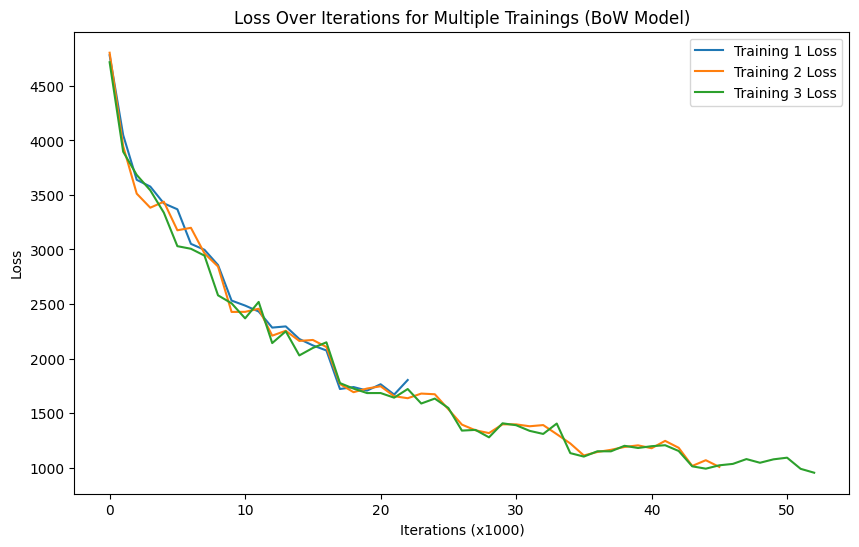

Average Test Accuracy: 0.3446
Test Accuracy Standard Deviation: 0.0454


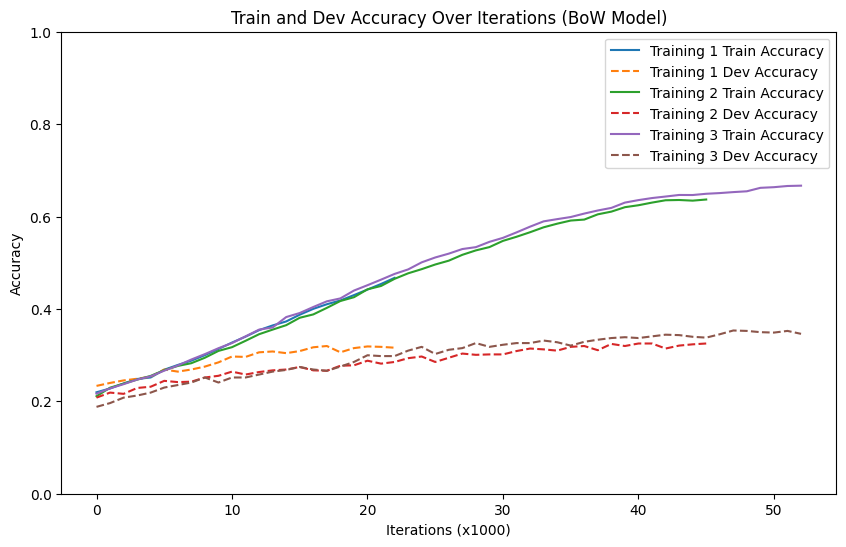

In [ ]:
# Aggregate and display results
for i, result in enumerate(results["bow_model"]):
    print(f"Training {i+1}:")
    print(f"  Final Test Loss: {result['test_loss']:.4f}")
    print(f"  Final Test Accuracy: {result['test_acc']:.4f}")


# Print average test loss
test_losses = [result["test_loss"] for result in results["bow_model"]]
print(f"Average Test Loss: {np.mean(test_losses):.4f}")

# Print standard deviation of test loss
print(f"Test Loss Standard Deviation: {np.std(test_losses):.4f}")

# Plot loss over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["bow_model"]):
    plt.plot(result["train_loss"], label=f"Training {i+1} Loss")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Loss")
plt.title("Loss Over Iterations for Multiple Trainings (BoW Model)")
plt.legend()

# Save plot
plt.savefig("plots/bow_loss.png")

plt.show()

# Print average test accuracy
test_accs = [result["test_acc"] for result in results["bow_model"]]
print(f"Average Test Accuracy: {np.mean(test_accs):.4f}")
# Print standard deviation of test accuracy
print(f"Test Accuracy Standard Deviation: {np.std(test_accs):.4f}")

# Plot accuracy over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["bow_model"]):
    plt.plot(result["train_acc"], label=f"Training {i+1} Train Accuracy")
    plt.plot(result["dev_acc"], label=f"Training {i+1} Dev Accuracy", linestyle="--")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Train and Dev Accuracy Over Iterations (BoW Model)")
plt.legend()

# Save plot
plt.savefig("plots/bow_acc.png")

plt.show()

Please note that we set the number of iterations to 30K as an indicative value, after which we simply stop training without checking for convergence. You should choose an appropriate number of iterations and motivate your decision. **This holds for all pre-set numbers of iteration in the following code blocks.**

# CBOW

We now continue with a **continuous bag-of-words (CBOW)** model. (*This is not the same as the word2vec CBOW model!*)

It is similar to the BOW model above, but now embeddings can have a dimension of *arbitrary size*.
This means that we can choose a higher dimensionality and learn more aspects of each word. We will still sum word vectors to get a sentence representation, but now the size of the resulting vector will no longer correspond to the number of sentiment classes.

So to turn the size of our summed vector into the number of output classes, we can *learn* a parameter matrix $W$ and multiply it by the sum vector $x$: $$Wx$$
If the size of $x$ is `d x 1`, we can set $W$ to be `5 x d`, so that the output of the matrix multiplication will be the of the desired size, `5 x 1`. Then, just like for the BOW model, we can obtain a prediction using the argmax function.

## Exercise: implement and train the CBOW model

Write a class `CBOW` that:

- has word embeddings with size 300
- sums the word vectors for the input words (just like in `BOW`)
- projects the resulting vector down to 5 units using a linear layer and a bias term (check out `nn.Linear`)

Train your CBOW model and plot the validation accuracy and training loss over time.

In [43]:
# YOUR CODE HERE

# Write a class CBOW that
# 1. has word embeddings with size 300
# 2. sums the word vectors for the input words
# 3. projects the resulting vector to 5 classes using a linear layer and a bias term

class CBOW(nn.Module):
    """A simple continuous bag-of-words model"""
    
    def __init__(self, vocab_size, embedding_dim, vocab, n_classes):
        super(CBOW, self).__init__()
        self.vocab = vocab
    
        # this is a trainable look-up table with word embeddings
        self.embed = nn.Embedding(vocab_size, embedding_dim)
    
        # this is a trainable bias term
        self.bias = nn.Parameter(torch.zeros(n_classes), requires_grad=True)
    
        # this is a trainable linear layer
        self.linear = nn.Linear(embedding_dim, n_classes)

    def forward(self, inputs):

        # this looks up the embeddings for each word ID in inputs
        # the result is a sequence of word embeddings
        embeds = self.embed(inputs)
        
        # the output is the sum across the time dimension (1)
        # with the bias term added
        logits = self.linear(embeds.sum(1)) + self.bias

        return logits

In [44]:
# Let's create a model.
vocab_size = len(v.w2i)
n_classes = len(t2i)
cbow_model = CBOW(vocab_size, 300, v, n_classes)
print(cbow_model)

# Let's print the parameters of the model
print_parameters(cbow_model)

CBOW(
  (embed): Embedding(18280, 300)
  (linear): Linear(in_features=300, out_features=5, bias=True)
)
bias                     [5]          requires_grad=True
embed.weight             [18280, 300] requires_grad=True
linear.weight            [5, 300]     requires_grad=True
linear.bias              [5]          requires_grad=True

Total number of parameters: 5485510



In [48]:
# Train the CBOW model

results["cbow_model"] = []

for i in range(NUM_TRAININGS):
    print(f"Training {i+1}/{NUM_TRAININGS}")
    cbow_model = CBOW(len(v.w2i), 300, vocab=v, n_classes=len(t2i))
    cbow_model = cbow_model.to(device)
    optimizer = optim.Adam(cbow_model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = MultiStepLR(optimizer, milestones=[40000, 60000, 70000, 80000, 90000,], gamma=0.5)
    results_iter, model = train_model(
        cbow_model, optimizer, num_iterations=100000,
        print_every=1000, eval_every=1000, scheduler=scheduler, early_stopping_patience=10)
    
    results["cbow_model"].append(results_iter)

    # Save model
    path = "models/cbow_model_{}.pt".format(i+1)
    torch.save(model.state_dict(), path)

Training 1/3
Shuffling training data
Iter 1000: loss=2669.3522, time=9.41s
iter 1000: dev acc=0.2534
new highscore
Iter 2000: loss=2299.4679, time=25.73s
iter 2000: dev acc=0.2788
new highscore
Iter 3000: loss=2116.5709, time=41.81s
iter 3000: dev acc=0.2725
No improvement. Early stopping counter: 1/10
Iter 4000: loss=2138.5596, time=58.15s
iter 4000: dev acc=0.3097
new highscore
Iter 5000: loss=2096.1003, time=74.41s
iter 5000: dev acc=0.3115
new highscore
Iter 6000: loss=2032.2526, time=90.73s
iter 6000: dev acc=0.2934
No improvement. Early stopping counter: 1/10
Iter 7000: loss=2003.3643, time=107.10s
iter 7000: dev acc=0.3324
new highscore
Iter 8000: loss=1977.2495, time=123.49s
iter 8000: dev acc=0.3124
No improvement. Early stopping counter: 1/10
Shuffling training data
Iter 9000: loss=1739.3993, time=139.78s
iter 9000: dev acc=0.3088
No improvement. Early stopping counter: 2/10
Iter 10000: loss=1633.3827, time=156.05s
iter 10000: dev acc=0.3124
No improvement. Early stopping cou

/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/1526041850.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


Shuffling training data
best model iter 19000: train acc=0.4929, dev acc=0.3615, test acc=0.3715
Training 2/3
Shuffling training data
Iter 1000: loss=2751.8564, time=9.73s
iter 1000: dev acc=0.2489
new highscore
Iter 2000: loss=2220.7519, time=26.67s
iter 2000: dev acc=0.2906
new highscore
Iter 3000: loss=2144.2640, time=43.60s
iter 3000: dev acc=0.2707
No improvement. Early stopping counter: 1/10
Iter 4000: loss=2204.6642, time=59.86s
iter 4000: dev acc=0.3152
new highscore
Iter 5000: loss=2057.3573, time=75.94s
iter 5000: dev acc=0.3324
new highscore
Iter 6000: loss=2079.1711, time=92.64s
iter 6000: dev acc=0.3170
No improvement. Early stopping counter: 1/10
Iter 7000: loss=1990.2031, time=109.05s
iter 7000: dev acc=0.3034
No improvement. Early stopping counter: 2/10
Iter 8000: loss=1963.1894, time=125.87s
iter 8000: dev acc=0.2888
No improvement. Early stopping counter: 3/10
Shuffling training data
Iter 9000: loss=1766.2667, time=142.47s
iter 9000: dev acc=0.3079
No improvement. Ear

Training 1:
  Final Test Loss: 4245.5355
  Final Test Accuracy: 0.3715
Training 2:
  Final Test Loss: 4392.3341
  Final Test Accuracy: 0.3557
Training 3:
  Final Test Loss: 4183.7662
  Final Test Accuracy: 0.3602
Average Test Loss: 4273.8786
Test Loss Standard Deviation: 87.4743


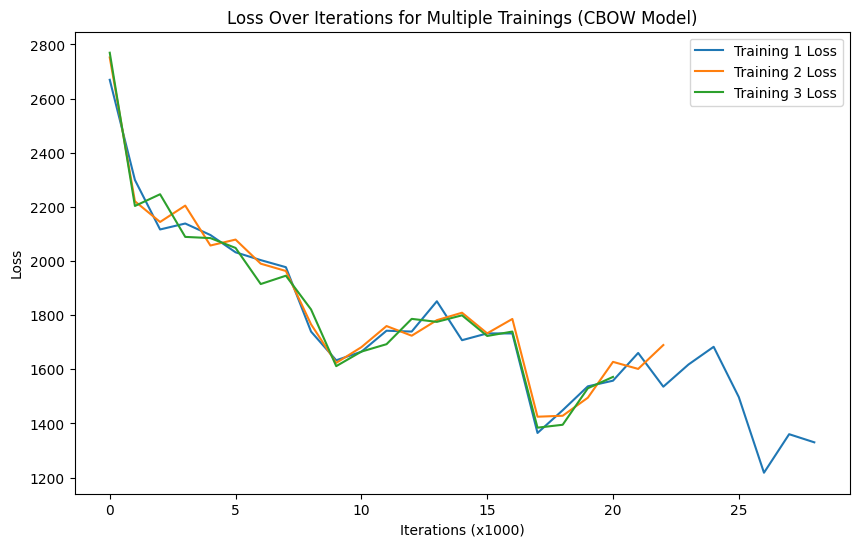

Average Test Accuracy: 0.3624
Test Accuracy Standard Deviation: 0.0067


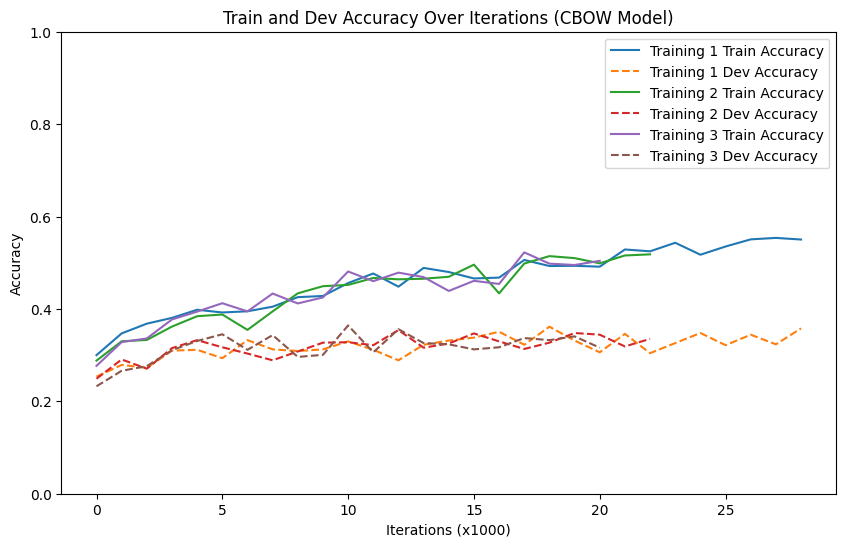

In [64]:
# Aggregate and display results
for i, result in enumerate(results["cbow_model"]):
    print(f"Training {i+1}:")
    print(f"  Final Test Loss: {result['test_loss']:.4f}")
    print(f"  Final Test Accuracy: {result['test_acc']:.4f}")

# Print average test loss
test_losses = [result["test_loss"] for result in results["cbow_model"]]
print(f"Average Test Loss: {np.mean(test_losses):.4f}")

# Print standard deviation of test loss
print(f"Test Loss Standard Deviation: {np.std(test_losses):.4f}")

# Plot loss over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["cbow_model"]):
    plt.plot(result["train_loss"], label=f"Training {i+1} Loss")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Loss")
plt.title("Loss Over Iterations for Multiple Trainings (CBOW Model)")
plt.legend()
# Save plot
plt.savefig("plots/cbow_loss.png")
plt.show()

# Print average test accuracy
test_accs = [result["test_acc"] for result in results["cbow_model"]]
print(f"Average Test Accuracy: {np.mean(test_accs):.4f}")

# Print standard deviation of test accuracy
print(f"Test Accuracy Standard Deviation: {np.std(test_accs):.4f}")

# Plot accuracy over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["cbow_model"]):
    plt.plot(result["train_acc"], label=f"Training {i+1} Train Accuracy")
    plt.plot(result["dev_acc"], label=f"Training {i+1} Dev Accuracy", linestyle="--")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Train and Dev Accuracy Over Iterations (CBOW Model)")
plt.legend()
# Save plot
plt.savefig("plots/cbow_acc.png")
plt.show()

# Deep CBOW

To see if we can squeeze some more performance out of the CBOW model, we can make it deeper and non-linear by adding more layers and, e.g., tanh-activations.
By using more parameters we can learn more aspects of the data, and by using more layers and non-linearities, we can try to learn a more complex function.
This is not something that always works. If the input-output mapping of your data is simple, then a complicated function could easily overfit on your training set, thereby leading to poor generalization.

#### Exercise: write Deep CBOW class and train it

Write a class `DeepCBOW`.

In your code, make sure that your `output_layer` consists of the following:
- A linear transformation from E units to D units.
- A Tanh activation
- A linear transformation from D units to D units
- A Tanh activation
- A linear transformation from D units to 5 units (our output classes).

E is the size of the word embeddings (please use E=300) and D for the size of a hidden layer (please use D=100).

We recommend using [nn.Sequential](https://pytorch.org/docs/stable/nn.html?highlight=sequential#torch.nn.Sequential) to implement this exercise.

In [50]:
# YOUR CODE HERE

class DeepCBOW(nn.Module):
    """
    A deep continuous bag-of-words model

    Arquitecture:
    - Linear transformation from E to D units
    - TanH activation function
    - Linear transformation from D to D units
    - TanH activation function
    - Linear transformation from D to 5 units

    Default values:
    - E = 300
    - D = 100

    Must use nn.Sequential for the layers
    """

    def __init__(self, vocab_size, vocab, embedding_dim=300, n_classes=5, D=100):
        super(DeepCBOW, self).__init__()
        self.vocab = vocab

        # this is a trainable look-up table with word embeddings
        self.embed = nn.Embedding(vocab_size, embedding_dim)

        # this is a trainable net with 3 linear layers
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, D),
            nn.Tanh(),
            nn.Linear(D, D),
            nn.Tanh(),
            nn.Linear(D, n_classes)
        )

    def forward(self, inputs):
            
            # this looks up the embeddings for each word ID in inputs
            # the result is a sequence of word embeddings
            embeds = self.embed(inputs)
    
            # the output is the sum across the time dimension (1)
            # with the bias term added
            logits = self.net(embeds.sum(1))
    
            return logits

In [51]:

# Let's create a model.
vocab_size = len(v.w2i)
n_classes = len(t2i)
deep_cbow_model = DeepCBOW(vocab_size, v)
print(deep_cbow_model)

# Let's print the parameters of the model
print_parameters(deep_cbow_model)

DeepCBOW(
  (embed): Embedding(18280, 300)
  (net): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=5, bias=True)
  )
)
embed.weight             [18280, 300] requires_grad=True
net.0.weight             [100, 300]   requires_grad=True
net.0.bias               [100]        requires_grad=True
net.2.weight             [100, 100]   requires_grad=True
net.2.bias               [100]        requires_grad=True
net.4.weight             [5, 100]     requires_grad=True
net.4.bias               [5]          requires_grad=True

Total number of parameters: 5524705



In [53]:
# Train the Deep CBOW model

results["deep_cbow_model"] = []

for i in range(NUM_TRAININGS):
    print(f"Training {i+1}/{NUM_TRAININGS}")
    deep_cbow_model = DeepCBOW(len(v.w2i), vocab=v)
    deep_cbow_model = deep_cbow_model.to(device)
    optimizer = optim.Adam(deep_cbow_model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = MultiStepLR(optimizer, milestones=[40000, 60000, 70000, 80000, 90000,], gamma=0.5)
    results_iter, model = train_model(
        deep_cbow_model, optimizer, num_iterations=100000,
        print_every=1000, eval_every=1000, scheduler=scheduler, early_stopping_patience=10)
    
    results["deep_cbow_model"].append(results_iter)

    # Save model
    path = "models/deep_cbow_model_{}.pt".format(i+1)
    torch.save(model.state_dict(), path)

Training 1/3
Shuffling training data
Iter 1000: loss=1611.3289, time=9.39s
iter 1000: dev acc=0.2407
new highscore
Iter 2000: loss=1575.6288, time=27.80s
iter 2000: dev acc=0.3034
new highscore
Iter 3000: loss=1568.9000, time=46.80s
iter 3000: dev acc=0.2870
No improvement. Early stopping counter: 1/10
Iter 4000: loss=1576.0970, time=65.30s
iter 4000: dev acc=0.2698
No improvement. Early stopping counter: 2/10
Iter 5000: loss=1556.3954, time=82.88s
iter 5000: dev acc=0.2688
No improvement. Early stopping counter: 3/10
Iter 6000: loss=1554.2918, time=99.97s
iter 6000: dev acc=0.2861
No improvement. Early stopping counter: 4/10
Iter 7000: loss=1550.6539, time=117.00s
iter 7000: dev acc=0.3134
new highscore
Iter 8000: loss=1541.7293, time=134.33s
iter 8000: dev acc=0.3106
No improvement. Early stopping counter: 1/10
Shuffling training data
Iter 9000: loss=1520.7889, time=151.82s
iter 9000: dev acc=0.3379
new highscore
Iter 10000: loss=1503.4999, time=169.79s
iter 10000: dev acc=0.3433
new

/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/1526041850.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


Shuffling training data
best model iter 21000: train acc=0.4319, dev acc=0.3706, test acc=0.3688
Training 2/3
Shuffling training data
Iter 1000: loss=1618.6975, time=9.88s
iter 1000: dev acc=0.2834
new highscore
Iter 2000: loss=1570.1514, time=27.11s
iter 2000: dev acc=0.3034
new highscore
Iter 3000: loss=1583.0831, time=44.77s
iter 3000: dev acc=0.2997
No improvement. Early stopping counter: 1/10
Iter 4000: loss=1576.6481, time=61.55s
iter 4000: dev acc=0.2543
No improvement. Early stopping counter: 2/10
Iter 5000: loss=1543.9792, time=78.59s
iter 5000: dev acc=0.2843
No improvement. Early stopping counter: 3/10
Iter 6000: loss=1549.9562, time=95.76s
iter 6000: dev acc=0.2843
No improvement. Early stopping counter: 4/10
Iter 7000: loss=1524.9787, time=112.79s
iter 7000: dev acc=0.2979
No improvement. Early stopping counter: 5/10
Iter 8000: loss=1565.5759, time=130.15s
iter 8000: dev acc=0.3043
new highscore
Shuffling training data
Iter 9000: loss=1483.8990, time=147.46s
iter 9000: dev

Training 1:
  Final Test Loss: 3165.3774
  Final Test Accuracy: 0.3688
Training 2:
  Final Test Loss: 3325.9093
  Final Test Accuracy: 0.3873
Training 3:
  Final Test Loss: 3179.8305
  Final Test Accuracy: 0.3824
Average Test Loss: 3223.7057
Test Loss Standard Deviation: 72.5093


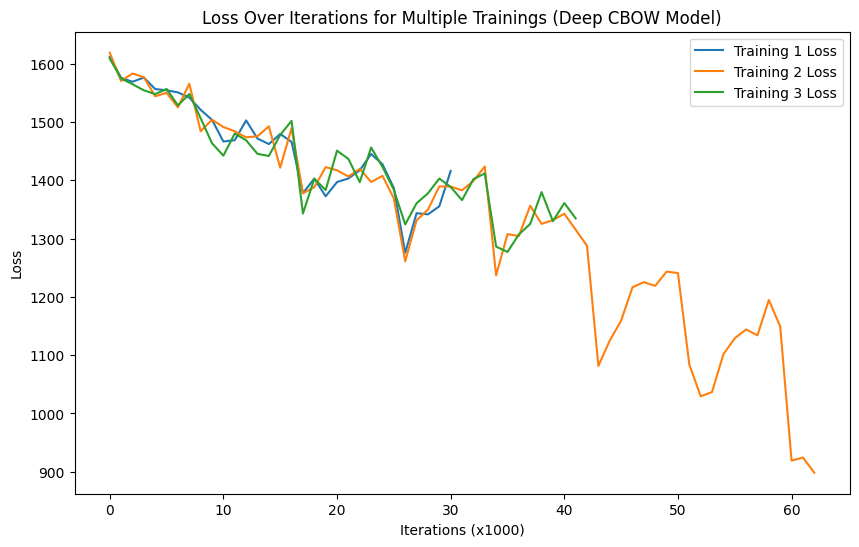

Average Test Accuracy: 0.3795
Test Accuracy Standard Deviation: 0.0078


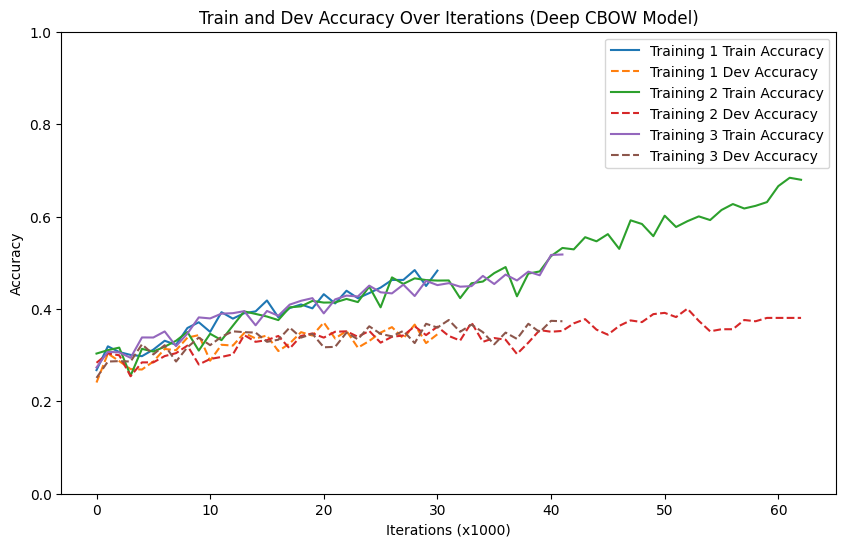

In [65]:
# Aggregate and display results

for i, result in enumerate(results["deep_cbow_model"]):
    print(f"Training {i+1}:")
    print(f"  Final Test Loss: {result['test_loss']:.4f}")
    print(f"  Final Test Accuracy: {result['test_acc']:.4f}")

# Print average test loss
test_losses = [result["test_loss"] for result in results["deep_cbow_model"]]
print(f"Average Test Loss: {np.mean(test_losses):.4f}")

# Print standard deviation of test loss
print(f"Test Loss Standard Deviation: {np.std(test_losses):.4f}")

# Plot loss over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["deep_cbow_model"]):
    plt.plot(result["train_loss"], label=f"Training {i+1} Loss")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Loss")
plt.title("Loss Over Iterations for Multiple Trainings (Deep CBOW Model)")
plt.legend()
# Save plot
plt.savefig("plots/deep_cbow_loss.png")
plt.show()

# Print average test accuracy
test_accs = [result["test_acc"] for result in results["deep_cbow_model"]]
print(f"Average Test Accuracy: {np.mean(test_accs):.4f}")

# Print standard deviation of test accuracy
print(f"Test Accuracy Standard Deviation: {np.std(test_accs):.4f}")

# Plot accuracy over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["deep_cbow_model"]):
    plt.plot(result["train_acc"], label=f"Training {i+1} Train Accuracy")
    plt.plot(result["dev_acc"], label=f"Training {i+1} Dev Accuracy", linestyle="--")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Train and Dev Accuracy Over Iterations (Deep CBOW Model)")
plt.legend()
# Save plot
plt.savefig("plots/deep_cbow_acc.png")
plt.show()

# Pre-trained word embeddings

The Stanford Sentiment Treebank is a rather small data set, since it required fine-grained manual annotatation. This makes it difficult for the Deep CBOW model to learn good word embeddings, i.e. to learn good word representations for the words in our vocabulary.
In fact, the only error signal that the network receives is from predicting the sentiment of entire sentences!

To start off with better word representations, we can download **pre-trained word embeddings**.
You can choose which pre-trained word embeddings to use:

- **GloVe**. The "original" Stanford Sentiment classification [paper](http://aclweb.org/anthology/P/P15/P15-1150.pdf) used Glove embeddings, which are just another method (like *word2vec*) to get word embeddings from unannotated text. Glove is described in the following paper which you should cite if you use them:
> Jeffrey Pennington, Richard Socher, and Christopher Manning. ["Glove: Global vectors for word representation."](https://nlp.stanford.edu/pubs/glove.pdf) EMNLP 2014.

- **Word2Vec**. This is the method that you learned about in class, described in:
> Mikolov, Tomas, et al. ["Distributed representations of words and phrases and their compositionality."](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) Advances in neural information processing systems. 2013.

Using these pre-trained word embeddings, we can initialize our word embedding lookup table and start form a point where similar words are already close to one another in the distributional semantic space.

You can choose to keep the word embeddings **fixed** or to train them further, specialising them to the task at hand.
We will keep them fixed for now.

For the purposes of this lab, it is enough if you understand how word2vec works (whichever vectors you use), but if you are interested, we encourage you to also check out the GloVe paper.

You can either download the word2vec vectors, or the Glove vectors.
If you want to compare your results to the Stanford paper later on, then you should use Glove.
**At the end of this lab you have the option to compare which vectors give you the best performance. For now, simply choose one of them and continue with that.**

[**OPTIONAL in case you don't want to mount Google Drive:** instead of running all the 5 boxes below, you can 1) download the GloVe and word2vec in your local machine, 2) upload them on your Drive folder ("My Drive"). Then, uncomment the first 2 lines in box 6 before writing your code!]


In [ ]:
# This downloads the Glove 840B 300d embeddings.
# The original file is at http://nlp.stanford.edu/data/glove.840B.300d.zip
# Since that file is 2GB, we provide you with a *filtered version*
# which contains all the words you need for this data set.

# You only need to do this once.
# Please comment this cell out after downloading.

#!wget https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt

--2024-11-21 16:40:09--  https://gist.githubusercontent.com/bastings/b094de2813da58056a05e8e7950d4ad1/raw/3fbd3976199c2b88de2ae62afc0ecc6f15e6f7ce/glove.840B.300d.sst.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53933315 (51M) [text/plain]
Saving to: ‘glove.840B.300d.sst.txt’

glove.840B.300d.sst 100%[===================>]  51,43M  19,6MB/s    in 2,6s    

2024-11-21 16:40:15 (19,6 MB/s) - ‘glove.840B.300d.sst.txt’ saved [53933315/53933315]



In [175]:
# This downloads the word2vec 300D Google News vectors
# The file has been truncated to only contain words that appear in our data set.
# You can find the original file here: https://code.google.com/archive/p/word2vec/

# You only need to do this once.
# Please comment this out after downloading.
#!wget https://gist.githubusercontent.com/bastings/4d1c346c68969b95f2c34cfbc00ba0a0/raw/76b4fefc9ef635a79d0d8002522543bc53ca2683/googlenews.word2vec.300d.txt

--2024-11-21 16:40:23--  https://gist.githubusercontent.com/bastings/4d1c346c68969b95f2c34cfbc00ba0a0/raw/76b4fefc9ef635a79d0d8002522543bc53ca2683/googlenews.word2vec.300d.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66209703 (63M) [text/plain]
Saving to: ‘googlenews.word2vec.300d.txt’

googlenews.word2vec 100%[===================>]  63,14M  20,0MB/s    in 3,2s    

2024-11-21 16:40:32 (20,0 MB/s) - ‘googlenews.word2vec.300d.txt’ saved [66209703/66209703]



In [ ]:
# Mount Google Drive (to save the downloaded files)
# from google.colab import drive
# drive.mount('/gdrive')

In [ ]:
# Copy word vectors *to* Google Drive

# You only need to do this once.
# Please comment this out after running it.
# !cp "glove.840B.300d.sst.txt" "/gdrive/My Drive/"
# !cp "googlenews.word2vec.300d.txt" "/gdrive/My Drive/"

In [ ]:
# If you copied the word vectors to your Drive before,
# here is where you copy them back to the Colab notebook.

# Copy Glove vectors *from* Google Drive
# !cp "/gdrive/My Drive/glove.840B.300d.sst.txt" .
# !cp "/gdrive/My Drive/googlenews.word2vec.300d.txt" .

In [ ]:
# Uncomment these 2 lines below if went for the OPTIONAL method described above
# !cp "glove.840B.300d.sst.txt" "./"
# !cp "googlenews.word2vec.300d.txt" "./"

At this point you have the pre-trained word embedding files, but what do they look like?

In [55]:
# Exercise: Print the first 4 lines of the files that you downloaded.
# What do you see?

print("Glove\n")
with open("glove.840B.300d.sst.txt", "r") as f:
    for i in range(4):
        print(f.readline().strip())
    print(f"Embedding dimension: {len(f.readline().strip().split()) - 1 }") # The one is to remove the word

print("\nword2vec\n")

with open("googlenews.word2vec.300d.txt", "r") as f:
    for i in range(4):
        print(f.readline().strip())
    print(f"Embedding dimension: {len(f.readline().strip().split()) -1 }") # The one is to remove the word



Glove

, -0.082752 0.67204 -0.14987 -0.064983 0.056491 0.40228 0.0027747 -0.3311 -0.30691 2.0817 0.031819 0.013643 0.30265 0.0071297 -0.5819 -0.2774 -0.062254 1.1451 -0.24232 0.1235 -0.12243 0.33152 -0.006162 -0.30541 -0.13057 -0.054601 0.037083 -0.070552 0.5893 -0.30385 0.2898 -0.14653 -0.27052 0.37161 0.32031 -0.29125 0.0052483 -0.13212 -0.052736 0.087349 -0.26668 -0.16897 0.015162 -0.0083746 -0.14871 0.23413 -0.20719 -0.091386 0.40075 -0.17223 0.18145 0.37586 -0.28682 0.37289 -0.16185 0.18008 0.3032 -0.13216 0.18352 0.095759 0.094916 0.008289 0.11761 0.34046 0.03677 -0.29077 0.058303 -0.027814 0.082941 0.1862 -0.031494 0.27985 -0.074412 -0.13762 -0.21866 0.18138 0.040855 -0.113 0.24107 0.3657 -0.27525 -0.05684 0.34872 0.011884 0.14517 -0.71395 0.48497 0.14807 0.62287 0.20599 0.58379 -0.13438 0.40207 0.18311 0.28021 -0.42349 -0.25626 0.17715 -0.54095 0.16596 -0.036058 0.08499 -0.64989 0.075549 -0.28831 0.40626 -0.2802 0.094062 0.32406 0.28437 -0.26341 0.11553 0.071918 -0.47215 -0.183

#### Exercise: New Vocabulary

Since we now use pre-trained word embeddings, we need to create a new vocabulary.
This is because of two reasons:

1. We do not have pre-trained word embeddings for all words in our SST training set, and we do not want words in our vocabulary for which we have no word embeddings.
2. We should be able to look up the pre-trained word embedding for words in the validation and test set, even if these words are unseen in training.

Now, create a new vocabulary object `v` based on the word set of pre-trained embeddings, and load the corresponding embeddings into a list `vectors`.

The vocabulary `v` should consist of:
 - a  `<unk>` token at position 0,
 - a  `<pad>` token at position 1,
 - and then all words in the pre-trained embedding set.


After storing each vector in a list `vectors`, turn the list into a numpy matrix like this:
```python
 vectors = np.stack(vectors, axis=0)
```

Remember to add new embeddings for the `<unk>` and `<pad>` tokens, as they're not part of the word2vec/GloVe embeddings. These embeddings can be randomly initialized or 0-valued, think about what makes sense and see what the effects are.


In [56]:
# YOUR CODE HERE -> WE ARE IMPLEMENTING GLOVE, later we implement word2vec as well
v =  Vocabulary()
vectors = []

# Add <unk> and <pad> tokens
v.add_token("<unk>")
v.add_token("<pad>")
vectors.append(np.zeros(300)) # <unk>
vectors.append(np.zeros(300)) # <pad>

# Add the rest of the words
with open("glove.840B.300d.sst.txt", "r") as f:
    for line in f:
        word, *vector = line.strip().split()
        v.add_token(word)
        vectors.append(np.array(vector, dtype=np.float32))

vectors = np.stack(vectors, axis=0)

#### Exercise: words not in our pre-trained set

How many words in the training, dev, and test set are also in your vector set?
How many words are not there?

Store the words that are not in the word vector set in the set below.

In [57]:
words_not_found = set()
# YOUR CODE HERE
words_not_found_train = set()
words_not_found_dev = set()
words_not_found_test = set()

# Words in the training set that are not in the word vector set
for example in train_data:
    for token in example.tokens:
        if token not in v.w2i:
            words_not_found_train.add(token)

# Words in the dev set that are not in the word vector set
for example in dev_data:
    for token in example.tokens:
        if token not in v.w2i:
            words_not_found_dev.add(token)

# Words in the test set that are not in the word vector set
for example in test_data:
    for token in example.tokens:
        if token not in v.w2i:
            words_not_found_test.add(token)

words_not_found = words_not_found_train.intersection(words_not_found_dev).intersection(words_not_found_test)

print(f"Words not found in training set: {len(words_not_found_train)}")
print(f"Words not found in dev set: {len(words_not_found_dev)}")
print(f"Words not found in test set: {len(words_not_found_test)}")
print(f"Union of those sets: {len(words_not_found_train.union(words_not_found_dev).union(words_not_found_test))}")
print(f"Words not found in all sets (Intersection of the sets): {len(words_not_found)}")
print(f"Words not found in all sets: {list(words_not_found)}")

Words not found in training set: 699
Words not found in dev set: 105
Words not found in test set: 190
Union of those sets: 976
Words not found in all sets (Intersection of the sets): 5
Words not found in all sets: ['-LRB-', 'Birot', 'Seldahl', 'Wollter', '-RRB-']


#### Exercise: train Deep CBOW with (fixed) pre-trained embeddings

Now train Deep CBOW again using the pre-trained word vectors.


In [58]:
# We define a new class that inherits from DeepCBOW.
class PTDeepCBOW(DeepCBOW):
  def __init__(self, vocab_size, vocab, embedding_dim=300, n_classes=5, hidden_dim=100):
    super(PTDeepCBOW, self).__init__(
        vocab_size, vocab, embedding_dim, n_classes, hidden_dim)

In [59]:
# Create a Deep CBOW model with pre-trained embeddings
# YOUR CODE HERE

# Create a Deep CBOW model with pre-trained embeddings

results["pt_glove_deep_cbow_model"] = []

for i in range(NUM_TRAININGS):
    print(f"Training {i+1}/{NUM_TRAININGS}")
    pt_glove_deep_cbow_model = PTDeepCBOW(len(v.w2i), vocab=v)
    pt_glove_deep_cbow_model = pt_glove_deep_cbow_model.to(device)
    pt_glove_deep_cbow_model.embed.weight.data.copy_(torch.tensor(vectors))
    pt_glove_deep_cbow_model.embed.weight.requires_grad = False
    optimizer = optim.Adam(pt_glove_deep_cbow_model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = MultiStepLR(optimizer, milestones=[40000, 60000, 70000, 80000, 90000,], gamma=0.5)
    results_iter, model = train_model(
        pt_glove_deep_cbow_model, optimizer, num_iterations=100000,
        print_every=1000, eval_every=1000, scheduler=scheduler, early_stopping_patience=10)
    
    results["pt_glove_deep_cbow_model"].append(results_iter)

    # Save model
    path = "models/pt_glove_deep_cbow_model_{}.pt".format(i+1)
    torch.save(model.state_dict(), path)

Training 1/3
Shuffling training data
Iter 1000: loss=1535.2358, time=3.03s
iter 1000: dev acc=0.3506
new highscore
Iter 2000: loss=1427.7704, time=15.08s
iter 2000: dev acc=0.3769
new highscore
Iter 3000: loss=1404.5836, time=27.27s
iter 3000: dev acc=0.3797
new highscore
Iter 4000: loss=1383.5504, time=39.39s
iter 4000: dev acc=0.2761
No improvement. Early stopping counter: 1/10
Iter 5000: loss=1400.3100, time=51.18s
iter 5000: dev acc=0.3179
No improvement. Early stopping counter: 2/10
Iter 6000: loss=1361.0243, time=62.95s
iter 6000: dev acc=0.3778
No improvement. Early stopping counter: 3/10
Iter 7000: loss=1368.4114, time=73.17s
iter 7000: dev acc=0.3787
No improvement. Early stopping counter: 4/10
Iter 8000: loss=1397.2541, time=84.17s
iter 8000: dev acc=0.3860
new highscore
Shuffling training data
Iter 9000: loss=1349.6349, time=95.02s
iter 9000: dev acc=0.3560
No improvement. Early stopping counter: 1/10
Iter 10000: loss=1351.1634, time=105.94s
iter 10000: dev acc=0.3978
new hi

/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/1526041850.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


Shuffling training data
best model iter 15000: train acc=0.4113, dev acc=0.4114, test acc=0.4109
Training 2/3
Shuffling training data
Iter 1000: loss=1505.0055, time=2.93s
iter 1000: dev acc=0.3406
new highscore
Iter 2000: loss=1438.4151, time=13.33s
iter 2000: dev acc=0.3624
new highscore
Iter 3000: loss=1390.3157, time=23.91s
iter 3000: dev acc=0.3515
No improvement. Early stopping counter: 1/10
Iter 4000: loss=1376.7567, time=34.92s
iter 4000: dev acc=0.3851
new highscore
Iter 5000: loss=1364.7312, time=45.08s
iter 5000: dev acc=0.3878
new highscore
Iter 6000: loss=1399.4242, time=55.33s
iter 6000: dev acc=0.4069
new highscore
Iter 7000: loss=1390.0122, time=65.54s
iter 7000: dev acc=0.4005
No improvement. Early stopping counter: 1/10
Iter 8000: loss=1359.4414, time=75.72s
iter 8000: dev acc=0.3878
No improvement. Early stopping counter: 2/10
Shuffling training data
Iter 9000: loss=1395.6279, time=86.03s
iter 9000: dev acc=0.3996
No improvement. Early stopping counter: 3/10
Iter 100

Training 1:
  Final Test Loss: 2918.4729
  Final Test Accuracy: 0.4109
Training 2:
  Final Test Loss: 2953.9901
  Final Test Accuracy: 0.4145
Training 3:
  Final Test Loss: 2909.1740
  Final Test Accuracy: 0.4294
Average Test Loss: 2927.2123
Test Loss Standard Deviation: 19.3116


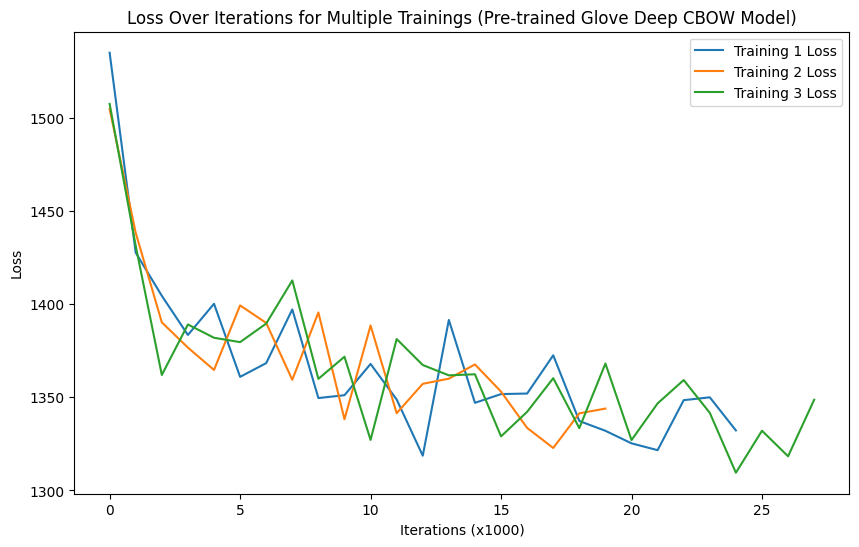

Average Test Accuracy: 0.4183
Test Accuracy Standard Deviation: 0.0080


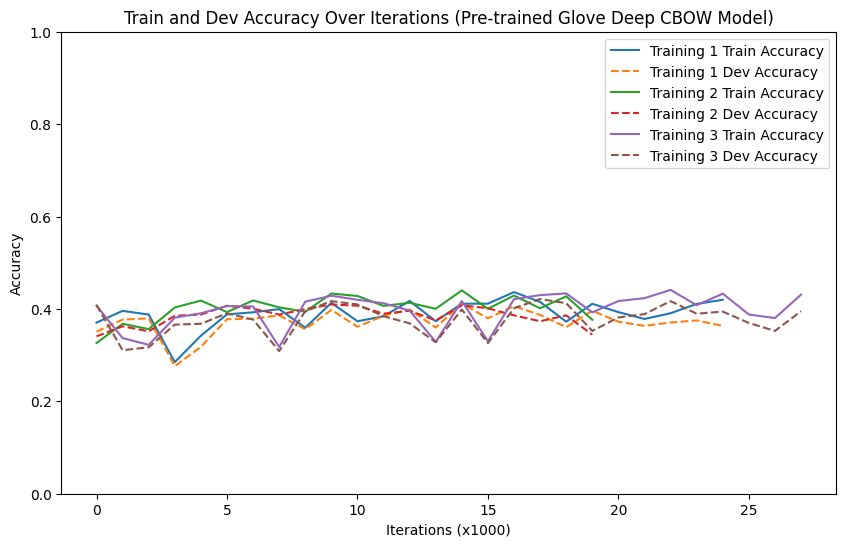

In [66]:
# Aggregate and display results

for i, result in enumerate(results["pt_glove_deep_cbow_model"]):
    print(f"Training {i+1}:")
    print(f"  Final Test Loss: {result['test_loss']:.4f}")
    print(f"  Final Test Accuracy: {result['test_acc']:.4f}")

# Print average test loss
test_losses = [result["test_loss"] for result in results["pt_glove_deep_cbow_model"]]
print(f"Average Test Loss: {np.mean(test_losses):.4f}")

# Print standard deviation of test loss
print(f"Test Loss Standard Deviation: {np.std(test_losses):.4f}")

# Plot loss over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["pt_glove_deep_cbow_model"]):
    plt.plot(result["train_loss"], label=f"Training {i+1} Loss")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Loss")
plt.title("Loss Over Iterations for Multiple Trainings (Pre-trained Glove Deep CBOW Model)")
plt.legend()
# Save plot
plt.savefig("plots/pt_glove_deep_cbow_loss.png")
plt.show()

# Print average test accuracy
test_accs = [result["test_acc"] for result in results["pt_glove_deep_cbow_model"]]
print(f"Average Test Accuracy: {np.mean(test_accs):.4f}")

# Print standard deviation of test accuracy
print(f"Test Accuracy Standard Deviation: {np.std(test_accs):.4f}")

# Plot accuracy over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["pt_glove_deep_cbow_model"]):
    plt.plot(result["train_acc"], label=f"Training {i+1} Train Accuracy")
    plt.plot(result["dev_acc"], label=f"Training {i+1} Dev Accuracy", linestyle="--")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Train and Dev Accuracy Over Iterations (Pre-trained Glove Deep CBOW Model)")
plt.legend()
# Save plot
plt.savefig("plots/pt_glove_deep_cbow_acc.png")
plt.show()

In [67]:
# Now we use the word2vec embeddings

# Load the word2vec embeddings
v_word2vec =  Vocabulary()

vectors_word2vec = []

# Add <unk> and <pad> tokens
v_word2vec.add_token("<unk>")
v_word2vec.add_token("<pad>")
vectors_word2vec.append(np.zeros(300)) # <unk>
vectors_word2vec.append(np.zeros(300)) # <pad>

# Add the rest of the words
with open("googlenews.word2vec.300d.txt", "r") as f:
    for line in f:
        word, *vector = line.strip().split()
        v_word2vec.add_token(word)
        vectors_word2vec.append(np.array(vector, dtype=np.float32))

vectors_word2vec = np.stack(vectors_word2vec, axis=0)

In [68]:
# Train the Deep CBOW model with word2vec embeddings

results["pt_word2vec_deep_cbow_model"] = []

for i in range(NUM_TRAININGS):
    print(f"Training {i+1}/{NUM_TRAININGS}")
    pt_word2vec_deep_cbow_model = PTDeepCBOW(len(v_word2vec.w2i), vocab=v_word2vec)
    pt_word2vec_deep_cbow_model = pt_word2vec_deep_cbow_model.to(device)
    pt_word2vec_deep_cbow_model.embed.weight.data.copy_(torch.tensor(vectors_word2vec))
    pt_word2vec_deep_cbow_model.embed.weight.requires_grad = False
    optimizer = optim.Adam(pt_word2vec_deep_cbow_model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = MultiStepLR(optimizer, milestones=[40000, 60000, 70000, 80000, 90000,], gamma=0.5)
    results_iter, model = train_model(
        pt_word2vec_deep_cbow_model, optimizer, num_iterations=100000,
        print_every=1000, eval_every=1000, scheduler=scheduler, early_stopping_patience=10)
    
    results["pt_word2vec_deep_cbow_model"].append(results_iter)

    # Save model
    path = "models/pt_word2vec_deep_cbow_model_{}.pt".format(i+1)
    torch.save(model.state_dict(), path)

Training 1/3
Shuffling training data
Iter 1000: loss=1481.0946, time=2.93s
iter 1000: dev acc=0.3152
new highscore
Iter 2000: loss=1389.4322, time=15.41s
iter 2000: dev acc=0.3651
new highscore
Iter 3000: loss=1340.2184, time=26.84s
iter 3000: dev acc=0.3951
new highscore
Iter 4000: loss=1367.9598, time=38.28s
iter 4000: dev acc=0.3842
No improvement. Early stopping counter: 1/10
Iter 5000: loss=1347.9699, time=50.53s
iter 5000: dev acc=0.3733
No improvement. Early stopping counter: 2/10
Iter 6000: loss=1336.7744, time=62.90s
iter 6000: dev acc=0.3996
new highscore
Iter 7000: loss=1389.0669, time=74.51s
iter 7000: dev acc=0.4096
new highscore
Iter 8000: loss=1387.1088, time=85.72s
iter 8000: dev acc=0.3896
No improvement. Early stopping counter: 1/10
Shuffling training data
Iter 9000: loss=1368.2827, time=96.17s
iter 9000: dev acc=0.3806
No improvement. Early stopping counter: 2/10
Iter 10000: loss=1306.2847, time=106.17s
iter 10000: dev acc=0.3642
No improvement. Early stopping counte

/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/1526041850.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


Shuffling training data
best model iter 15000: train acc=0.4526, dev acc=0.4305, test acc=0.4339
Training 2/3
Shuffling training data
Iter 1000: loss=1497.6004, time=2.88s
iter 1000: dev acc=0.3433
new highscore
Iter 2000: loss=1388.9902, time=13.04s
iter 2000: dev acc=0.3579
new highscore
Iter 3000: loss=1386.3486, time=23.77s
iter 3000: dev acc=0.4024
new highscore
Iter 4000: loss=1374.3855, time=34.09s
iter 4000: dev acc=0.3715
No improvement. Early stopping counter: 1/10
Iter 5000: loss=1363.1991, time=44.33s
iter 5000: dev acc=0.4033
new highscore
Iter 6000: loss=1375.3731, time=54.46s
iter 6000: dev acc=0.4187
new highscore
Iter 7000: loss=1309.2255, time=64.97s
iter 7000: dev acc=0.3297
No improvement. Early stopping counter: 1/10
Iter 8000: loss=1342.2211, time=75.55s
iter 8000: dev acc=0.4096
No improvement. Early stopping counter: 2/10
Shuffling training data
Iter 9000: loss=1298.4586, time=85.48s
iter 9000: dev acc=0.3470
No improvement. Early stopping counter: 3/10
Iter 100

Training 1:
  Final Test Loss: 2821.6368
  Final Test Accuracy: 0.4339
Training 2:
  Final Test Loss: 2907.3506
  Final Test Accuracy: 0.4407
Training 3:
  Final Test Loss: 2941.0647
  Final Test Accuracy: 0.4217
Average Test Loss: 2890.0174
Test Loss Standard Deviation: 50.2731


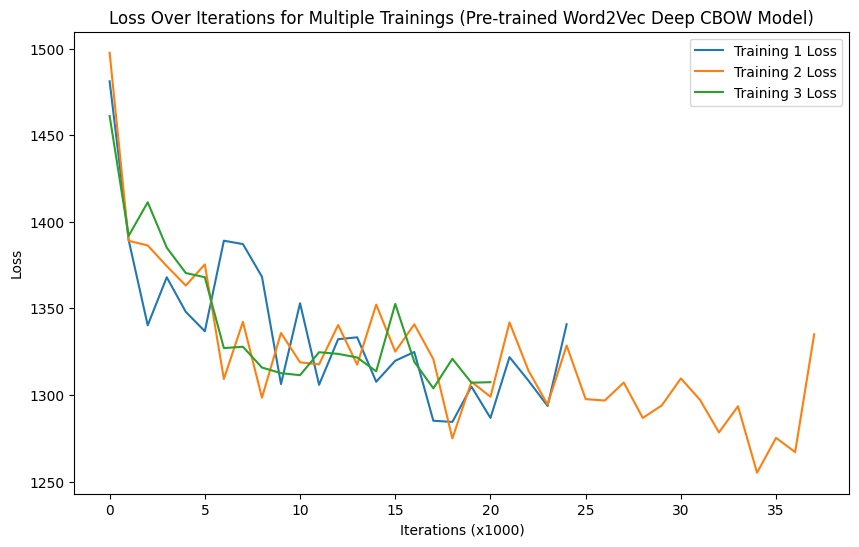

Average Test Accuracy: 0.4321
Test Accuracy Standard Deviation: 0.0079


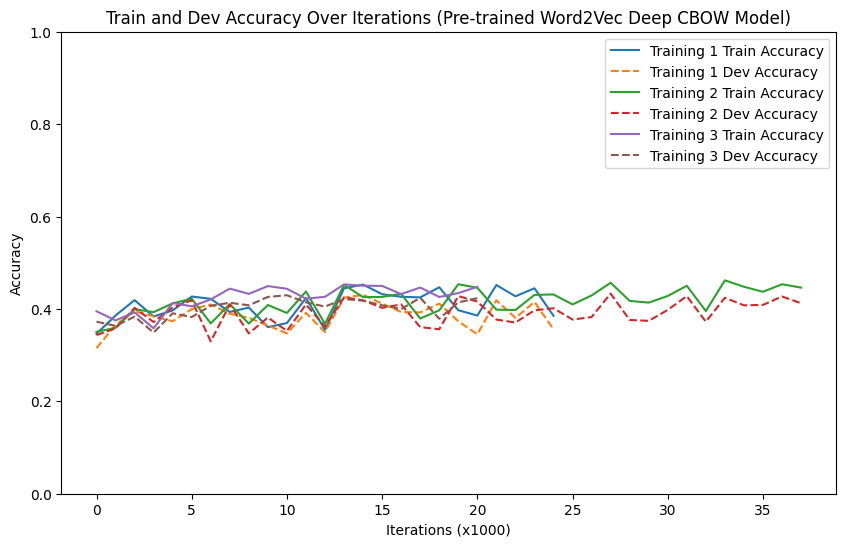

In [69]:
# Aggregate and display results

for i, result in enumerate(results["pt_word2vec_deep_cbow_model"]):
    print(f"Training {i+1}:")
    print(f"  Final Test Loss: {result['test_loss']:.4f}")
    print(f"  Final Test Accuracy: {result['test_acc']:.4f}")

# Print average test loss
test_losses = [result["test_loss"] for result in results["pt_word2vec_deep_cbow_model"]]
print(f"Average Test Loss: {np.mean(test_losses):.4f}")

# Print standard deviation of test loss
print(f"Test Loss Standard Deviation: {np.std(test_losses):.4f}")

# Plot loss over iterations for each training
plt.figure(figsize=(10, 6))

for i, result in enumerate(results["pt_word2vec_deep_cbow_model"]):
    plt.plot(result["train_loss"], label=f"Training {i+1} Loss")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Loss")

plt.title("Loss Over Iterations for Multiple Trainings (Pre-trained Word2Vec Deep CBOW Model)")
plt.legend()
# Save plot
plt.savefig("plots/pt_word2vec_deep_cbow_loss.png")
plt.show()

# Print average test accuracy
test_accs = [result["test_acc"] for result in results["pt_word2vec_deep_cbow_model"]]
print(f"Average Test Accuracy: {np.mean(test_accs):.4f}")

# Print standard deviation of test accuracy
print(f"Test Accuracy Standard Deviation: {np.std(test_accs):.4f}")

# Plot accuracy over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["pt_word2vec_deep_cbow_model"]):
    plt.plot(result["train_acc"], label=f"Training {i+1} Train Accuracy")
    plt.plot(result["dev_acc"], label=f"Training {i+1} Dev Accuracy", linestyle="--")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Train and Dev Accuracy Over Iterations (Pre-trained Word2Vec Deep CBOW Model)")
plt.legend()
# Save plot
plt.savefig("plots/pt_word2vec_deep_cbow_acc.png")
plt.show()

**It looks like we've hit what is possible with just using words.**
Let's move on by incorporating word order!

# LSTM

It is time to get more serious. Even with pre-trained word embeddings and multiple layers, we still seem to do pretty badly at sentiment classification.
The next step we can take is to introduce word order again, dropping our independence assumptions. In this way, we can get a representation of the sentence as an ordered set of tokens.

We will get this representation using a **Long Short-Term Memory** (LSTM). As an exercise, we will code our own LSTM cell, so that we get comfortable with its inner workings.
Once we have an LSTM cell, we can call it repeatedly, updating its hidden state one word at a time:

```python
rnn = MyLSTMCell(input_size, hidden_size)

hx = torch.zeros(1, hidden_size)  # initial hidden state
cx = torch.zeros(1, hidden_size)  # initial memory cell
output = []                       # to save intermediate LSTM states

# feed one word at a time
for i in range(n_timesteps):
  hx, cx = rnn(input[i], (hx, cx))
  output.append(hx)
```

If you need some more help understanding LSTMs, you can check out these resources:
- Blog post (highly recommended): http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Paper covering LSTM formulas in detail: https://arxiv.org/abs/1503.04069


#### Exercise: Finish the LSTM cell below.
You will need to implement the LSTM formulas:

$$
\begin{array}{ll}
        i = \sigma(W_{ii} x + b_{ii} + W_{hi} h + b_{hi}) \\
        f = \sigma(W_{if} x + b_{if} + W_{hf} h + b_{hf}) \\
        g = \tanh(W_{ig} x + b_{ig} + W_{hg} h + b_{hg}) \\
        o = \sigma(W_{io} x + b_{io} + W_{ho} h + b_{ho}) \\
        c' = f * c + i * g \\
        h' = o \tanh(c') \\
\end{array}
 $$

where $\sigma$ is the sigmoid function.

*Note that the LSTM formulas can differ slightly between different papers. We use the PyTorch LSTM formulation here.*

In [70]:
class MyLSTMCell(nn.Module):
  """Our own LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(MyLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    # YOUR CODE HERE
    # Weights for input x
    self.W_ii = nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.W_if = nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.W_ig = nn.Parameter(torch.Tensor(input_size, hidden_size))
    self.W_io = nn.Parameter(torch.Tensor(input_size, hidden_size))

    # Weights for hidden state h
    self.W_hi = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.W_hf = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.W_hg = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
    self.W_ho = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

    if bias:
        self.b_ii = nn.Parameter(torch.Tensor(hidden_size))
        self.b_if = nn.Parameter(torch.Tensor(hidden_size))
        self.b_ig = nn.Parameter(torch.Tensor(hidden_size))
        self.b_io = nn.Parameter(torch.Tensor(hidden_size))

        self.b_hi = nn.Parameter(torch.Tensor(hidden_size))
        self.b_hf = nn.Parameter(torch.Tensor(hidden_size))
        self.b_hg = nn.Parameter(torch.Tensor(hidden_size))
        self.b_ho = nn.Parameter(torch.Tensor(hidden_size))
    else:
        self.register_parameter('b_ii', None)
        self.register_parameter('b_if', None)
        self.register_parameter('b_ig', None)
        self.register_parameter('b_io', None)

        self.register_parameter('b_hi', None)
        self.register_parameter('b_hf', None)
        self.register_parameter('b_hg', None)
        self.register_parameter('b_ho', None)

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, input_, hx, mask=None):
    """
    input is (batch, input_size)
    hx is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h, prev_c = hx

    # project input and prev state
    # YOUR CODE HERE

    # main LSTM computation

    # Input gate computation
    i = torch.sigmoid(
            input_ @ self.W_ii + (self.b_ii if self.bias else 0) +
            prev_h @ self.W_hi + (self.b_hi if self.bias else 0)
        )
    # Forget gate computations
    f = torch.sigmoid(
            input_ @ self.W_if + (self.b_if if self.bias else 0) +
            prev_h @ self.W_hf + (self.b_hf if self.bias else 0)
        )

    # Cell candidate
    g = torch.tanh(
            input_ @ self.W_ig + (self.b_ig if self.bias else 0) +
            prev_h @ self.W_hg + (self.b_hg if self.bias else 0)
        )

    # Output gate
    o = torch.sigmoid(
            input_ @ self.W_io + (self.b_io if self.bias else 0) +
            prev_h @ self.W_ho + (self.b_ho if self.bias else 0)
        )

    # Update cell state
    c = f * prev_c + i * g
    
    # Compute new hidden state
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

#### Optional: Efficient Matrix Multiplication

It is more efficient to do a few big matrix multiplications than to do many smaller ones. So we will implement the above cell using just **two** linear layers.

This is possible because the eight linear transformations contained in one forward pass through an LSTM cell can be reduced to just two:
$$W_h h + b_h$$
$$W_i x + b_i $$

with $h = $ `prev_h` and $x = $ `input_`.

and where:

$W_h =  \begin{pmatrix}
W_{hi}\\
W_{hf}\\
W_{hg}\\
W_{ho}
\end{pmatrix}$, $b_h = \begin{pmatrix}
b_{hi}\\
b_{hf}\\
b_{hg}\\
b_{ho}
\end{pmatrix}$,  $W_i = \begin{pmatrix}
W_{ii}\\
W_{if}\\
W_{ig}\\
W_{io}
\end{pmatrix}$ and $b_i = \begin{pmatrix}
b_{ii}\\
b_{if}\\
b_{ig}\\
b_{io}
\end{pmatrix}$.

Convince yourself that, after chunking with [torch.chunk](https://pytorch.org/docs/stable/torch.html?highlight=chunk#torch.chunk), the output of those two linear transformations is equivalent to the output of the eight linear transformations in the LSTM cell calculations above.

In [71]:
import torch
import torch.nn as nn
import math

class MyEfficientLSTMCell(nn.Module):
    """Our own LSTM cell with efficient matrix multiplication"""

    def __init__(self, input_size, hidden_size, bias=True):
        """Creates the weights for this LSTM"""
        super(MyEfficientLSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # Combined weights for input x and hidden state h
        self.W_i = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.W_h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        """This is PyTorch's default initialization method"""
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, input_, hx):
        """
        input_ is (batch, input_size)
        hx is a tuple (prev_h, prev_c), each of shape (batch, hidden_size)
        """
        prev_h, prev_c = hx

        # Compute the combined transformations
        input_transformation = self.W_i(input_)
        hidden_transformation = self.W_h(prev_h)

        # Sum the transformations
        combined = input_transformation + hidden_transformation

        # Chunk the combined transformations into four parts
        i_gate, f_gate, g_gate, o_gate = torch.chunk(combined, chunks=4, dim=1)

        # Apply activation functions
        i = torch.sigmoid(i_gate)
        f = torch.sigmoid(f_gate)
        g = torch.tanh(g_gate)
        o = torch.sigmoid(o_gate)

        # Update cell state
        c = f * prev_c + i * g

        # Compute new hidden state
        h = o * torch.tanh(c)

        return h, c

    def __repr__(self):
        return "{}({:d}, {:d})".format(
            self.__class__.__name__, self.input_size, self.hidden_size)


#### LSTM Classifier

Having an LSTM cell is not enough: we still need some code that calls it repeatedly, and then makes a prediction from the final hidden state.
You will find that code below. Make sure that you understand it.

In [72]:
class LSTMClassifier(nn.Module):
  """Encodes sentence with an LSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(LSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.rnn = MyEfficientLSTMCell(embedding_dim, hidden_dim)

    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),  # explained later
        nn.Linear(hidden_dim, output_dim)
    )

  def forward(self, x):

    B = x.size(0)  # batch size (this is 1 for now, i.e. 1 single example)
    T = x.size(1)  # timesteps (the number of words in the sentence)

    input_ = self.embed(x)

    # here we create initial hidden states containing zeros
    # we use a trick here so that, if input is on the GPU, then so are hx and cx
    hx = input_.new_zeros(B, self.rnn.hidden_size)
    cx = input_.new_zeros(B, self.rnn.hidden_size)

    # process input sentences one word/timestep at a time
    # input is batch-major (i.e., batch size is the first dimension)
    # so the first word(s) is (are) input_[:, 0]
    outputs = []
    for i in range(T):
      hx, cx = self.rnn(input_[:, i], (hx, cx))
      outputs.append(hx)

    # if we have a single example, our final LSTM state is the last hx
    if B == 1:
      final = hx
    else:
      #
      # This part is explained in next section, ignore this else-block for now.
      #
      # We processed sentences with different lengths, so some of the sentences
      # had already finished and we have been adding padding inputs to hx.
      # We select the final state based on the length of each sentence.

      # two lines below not needed if using LSTM from pytorch
      outputs = torch.stack(outputs, dim=0)           # [T, B, D]
      outputs = outputs.transpose(0, 1).contiguous()  # [B, T, D]

      # to be super-sure we're not accidentally indexing the wrong state
      # we zero out positions that are invalid
      pad_positions = (x == 1).unsqueeze(-1)

      outputs = outputs.contiguous()
      outputs = outputs.masked_fill_(pad_positions, 0.)

      mask = (x != 1)  # true for valid positions [B, T]
      lengths = mask.sum(dim=1)                 # [B, 1]

      indexes = (lengths - 1) + torch.arange(B, device=x.device, dtype=x.dtype) * T
      final = outputs.view(-1, self.hidden_dim)[indexes]  # [B, D]

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(final)
    return logits

#### Dropout

Data sparsity and a small data set can cause *overfitting*. This is a phenomenom that is very likely to occur when training strong and expressive models, like LSTMs, on small data. In practice, if your model overfits, this means that it will be very good at predicting (or "remembering") the sentiment of the training set, but unable to generalise to new, unseen data in the test set. This is undesirable and one technique to mitigate this issue is *dropout*.

A dropout layer is defined by the following formula, which can be applied, for example, to a linear layer:

$$\text{tanh}(W(\mathbf{h}\odot \mathbf{d}) + \mathbf{b})$$

where $\mathbf{d} \in \{0, 1\}^n$, with $d_j \sim \text{Bernoulli}(p)$,

These formula simply means that we *drop* certain parameters during training (by setting them to zero). Which parameters we drop is stochastically determined by a Bernoulli distribution and the probability of each parameter being dropped is set to $p = 0.5$ in our experiments (see the previous cell of code where we define our output layer). A dropout layer can be applied at many different places in our models. This technique helps against the undesirable effect that a model relies on single parameters for prediction (e.g. if $h^{\prime}_j$ is large, always predict positive). If we use dropout, the model needs to learn to rely on different parameters, which is desirable to obtain better generalisation to unseen data.

**Let's train our LSTM!** Note that is will be a lot slower than previous models because we need to do many more computations per sentence.

#### Training

In [73]:
# lstm_model = LSTMClassifier(len(v.w2i), 300, 168, len(t2i), v)

# # NOTE FOR FUTURE: This execution is dependent on the vocabulary, we are now using Glove embeddings here, but it may be useful to train on word2vec and compare

# # copy pre-trained word vectors into embeddings table
# with torch.no_grad():
#   lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
#   lstm_model.embed.weight.requires_grad = False

# print(lstm_model)
# print_parameters(lstm_model)

# lstm_model = lstm_model.to(device)
# optimizer = optim.Adam(lstm_model.parameters(), lr=3e-4)
# scheduler = MultiStepLR(optimizer, milestones=[40000, 60000, 70000, 80000, 90000], gamma=0.5)

# lstm_losses, lstm_accuracies_dev, lstm_accuracies_train, lstm_test_loss, lstm_test_accuracy = train_model(
#     lstm_model, optimizer, num_iterations=100000,
#     print_every=250, eval_every=1000, scheduler=scheduler)

# Train the LSTM model

results["lstm_glove"] = []

for i in range(NUM_TRAININGS):
    print(f"Training {i+1}/{NUM_TRAININGS}")
    lstm_model = LSTMClassifier(len(v.w2i), 300, 168, len(t2i), v)
    lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
    lstm_model.embed.weight.requires_grad = False
    lstm_model = lstm_model.to(device)
    optimizer = optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = MultiStepLR(optimizer, milestones=[40000, 60000, 70000, 80000, 90000,], gamma=0.5)
    results_iter, model = train_model(
        lstm_model, optimizer, num_iterations=100000,
        print_every=1000, eval_every=1000, scheduler=scheduler, early_stopping_patience=10)
    
    results["lstm_glove"].append(results_iter)

    # Save model
    path = "models/lstm_glove_{}.pt".format(i+1)
    torch.save(model.state_dict(), path)

Training 1/3
Shuffling training data
Iter 1000: loss=1517.9304, time=16.79s
iter 1000: dev acc=0.3933
new highscore
Iter 2000: loss=1412.2946, time=86.12s
iter 2000: dev acc=0.3424
No improvement. Early stopping counter: 1/10
Iter 3000: loss=1406.8709, time=152.66s
iter 3000: dev acc=0.3688
No improvement. Early stopping counter: 2/10
Iter 4000: loss=1375.2505, time=218.82s
iter 4000: dev acc=0.4069
new highscore
Iter 5000: loss=1351.3548, time=284.65s
iter 5000: dev acc=0.4223
new highscore
Iter 6000: loss=1374.9942, time=351.70s
iter 6000: dev acc=0.4242
new highscore
Iter 7000: loss=1348.1668, time=418.86s
iter 7000: dev acc=0.4069
No improvement. Early stopping counter: 1/10
Iter 8000: loss=1287.2787, time=485.16s
iter 8000: dev acc=0.4114
No improvement. Early stopping counter: 2/10
Shuffling training data
Iter 9000: loss=1296.3386, time=550.77s
iter 9000: dev acc=0.4060
No improvement. Early stopping counter: 3/10
Iter 10000: loss=1263.2167, time=617.77s
iter 10000: dev acc=0.436

/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/1526041850.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


Shuffling training data
best model iter 28000: train acc=0.5836, dev acc=0.4614, test acc=0.4679
Training 2/3
Shuffling training data
Iter 1000: loss=1543.0049, time=16.48s
iter 1000: dev acc=0.3043
new highscore
Iter 2000: loss=1490.3919, time=83.53s
iter 2000: dev acc=0.3787
new highscore
Iter 3000: loss=1402.5000, time=150.35s
iter 3000: dev acc=0.3724
No improvement. Early stopping counter: 1/10
Iter 4000: loss=1383.6498, time=216.59s
iter 4000: dev acc=0.4005
new highscore
Iter 5000: loss=1369.9412, time=283.55s
iter 5000: dev acc=0.4124
new highscore
Iter 6000: loss=1361.2138, time=350.70s
iter 6000: dev acc=0.4078
No improvement. Early stopping counter: 1/10
Iter 7000: loss=1342.6131, time=415.98s
iter 7000: dev acc=0.3969
No improvement. Early stopping counter: 2/10
Iter 8000: loss=1313.3436, time=482.68s
iter 8000: dev acc=0.4078
No improvement. Early stopping counter: 3/10
Shuffling training data
Iter 9000: loss=1294.8801, time=548.92s
iter 9000: dev acc=0.4296
new highscore


Training 1:
  Final Test Loss: 2668.9513
  Final Test Accuracy: 0.4679
Training 2:
  Final Test Loss: 2622.5826
  Final Test Accuracy: 0.4787
Training 3:
  Final Test Loss: 2652.1067
  Final Test Accuracy: 0.4787
Average Test Loss: 2647.8802
Test Loss Standard Deviation: 19.1644


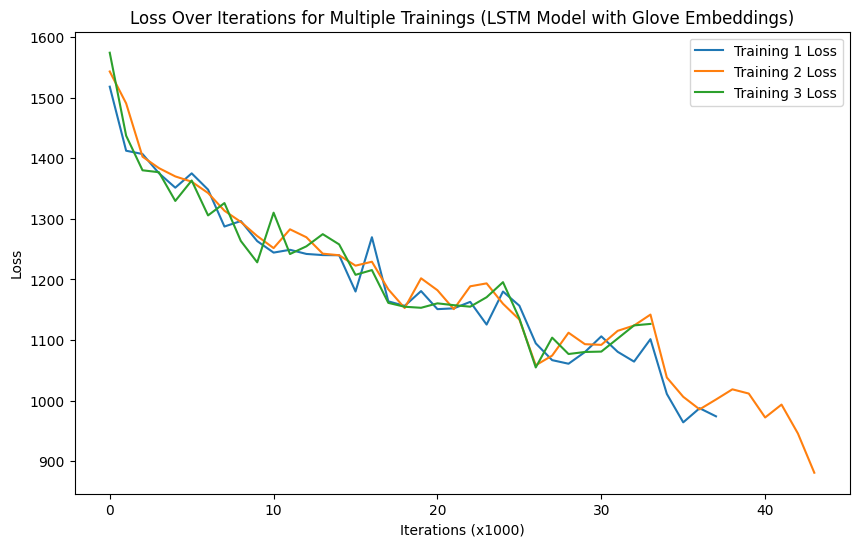

Average Test Accuracy: 0.4751
Test Accuracy Standard Deviation: 0.0051


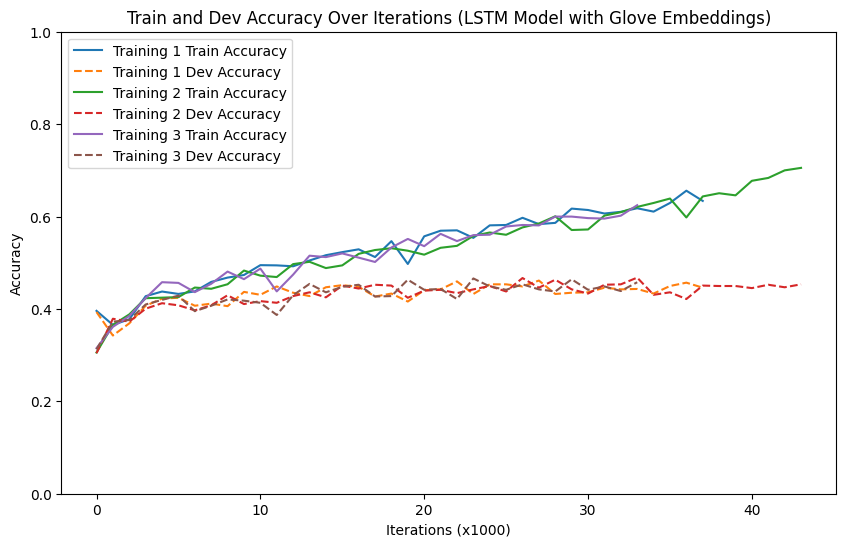

In [74]:
# Aggregate and display results

for i, result in enumerate(results["lstm_glove"]):
    print(f"Training {i+1}:")
    print(f"  Final Test Loss: {result['test_loss']:.4f}")
    print(f"  Final Test Accuracy: {result['test_acc']:.4f}")

# Print average test loss
test_losses = [result["test_loss"] for result in results["lstm_glove"]]
print(f"Average Test Loss: {np.mean(test_losses):.4f}")

# Print standard deviation of test loss
print(f"Test Loss Standard Deviation: {np.std(test_losses):.4f}")

# Plot loss over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["lstm_glove"]):
    plt.plot(result["train_loss"], label=f"Training {i+1} Loss")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Loss")
plt.title("Loss Over Iterations for Multiple Trainings (LSTM Model with Glove Embeddings)")
plt.legend()
# Save plot
plt.savefig("plots/lstm_glove_loss.png")
plt.show()

# Print average test accuracy
test_accs = [result["test_acc"] for result in results["lstm_glove"]]
print(f"Average Test Accuracy: {np.mean(test_accs):.4f}")

# Print standard deviation of test accuracy
print(f"Test Accuracy Standard Deviation: {np.std(test_accs):.4f}")

# Plot accuracy over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["lstm_glove"]):
    plt.plot(result["train_acc"], label=f"Training {i+1} Train Accuracy")
    plt.plot(result["dev_acc"], label=f"Training {i+1} Dev Accuracy", linestyle="--")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Train and Dev Accuracy Over Iterations (LSTM Model with Glove Embeddings)")
plt.legend()
# Save plot
plt.savefig("plots/lstm_glove_acc.png")
plt.show()

# Mini-batching



**Why is the LSTM so slow?** Despite our best efforts, we still need to make a lot of matrix multiplications per example (linear in the length of the example) just to get a single classification, and we can only process the 2nd word once we have computed the hidden state for the 1st word (sequential computation).

GPUs are more efficient if we do a few big matrix multiplications, rather than lots of small ones. If we could process multiple examples at the same time, then we could exploit that. That is, we could still process the input sequentially, but doing so for multiple sentences at the same time.

Up to now our "mini-batches" consisted of a single example. This was for a reason: the sentences in our data sets have **different lengths**, and this makes it difficult to process them at the same time.

Consider a batch of 2 sentences:

```
this movie is bad
this movie is super cool !
```

Let's say the IDs for these sentences are:

```
2 3 4 5
2 3 4 6 7 8
```

We cannot feed PyTorch an object with rows of variable length! We need to turn this into a matrix.

The solution is to add **padding values** to our mini-batch:

```
2 3 4 5 1 1
2 3 4 6 7 8
```

Whenever a sentence is shorter than the longest sentence in a mini-batch, we just use a padding value (here: 1) to fill the matrix.

In our computation, we should **ignore** the padding positions (e.g. mask them out) so that paddings do not contribute to the loss.

#### Mini-batch feed
We will now implement a `get_minibatch` function which will replace `get_example` and returns a mini-batch of the requested size.

In [82]:
def get_minibatch(data, batch_size=25, shuffle=True):
  """Return minibatches, optional shuffling"""

  if shuffle:
    print("Shuffling training data")
    random.shuffle(data)  # shuffle training data each epoch

  batch = []

  # yield minibatches
  for example in data:
    batch.append(example)

    if len(batch) == batch_size:
      yield batch
      batch = []

  # in case there is something left
  if len(batch) > 0:
    yield batch

#### Padding function
We will need a function that adds padding 1s to a sequence of IDs so that
it becomes as long as the longest sequence in the minibatch.

In [83]:
def pad(tokens, length, pad_value=1):
  """add padding 1s to a sequence to that it has the desired length"""
  return tokens + [pad_value] * (length - len(tokens))

# example
tokens = [2, 3, 4]
pad(tokens, 5)

[2, 3, 4, 1, 1]

#### New `prepare` function

We will also need a new function that turns a mini-batch into PyTorch tensors.

In [84]:
def prepare_minibatch(mb, vocab):
  """
  Minibatch is a list of examples.
  This function converts words to IDs and returns
  torch tensors to be used as input/targets.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])

  # vocab returns 0 if the word is not there
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen) for ex in mb]

  x = torch.LongTensor(x)
  x = x.to(device)

  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)

  return x, y

In [78]:
# Let's test our new function.
# This should give us 3 examples.
mb = next(get_minibatch(train_data, batch_size=3, shuffle=False))
for ex in mb:
  print(ex)

Example(tokens=['It', "'s", 'everything', 'you', "'d", 'expect', '--', 'but', 'nothing', 'more', '.'], tree=Tree('2', [Tree('2', ['It']), Tree('1', [Tree('2', [Tree('2', ["'s"]), Tree('1', [Tree('2', ['everything']), Tree('1', [Tree('2', ['you']), Tree('2', [Tree('2', ["'d"]), Tree('2', [Tree('2', [Tree('2', [Tree('2', ['expect']), Tree('2', ['--'])]), Tree('2', [Tree('2', ['but']), Tree('1', ['nothing'])])]), Tree('2', ['more'])])])])])]), Tree('2', ['.'])])]), label=2, transitions=[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1])
Example(tokens=['Shamelessly', 'resorting', 'to', 'pee-related', 'sight', 'gags', 'that', 'might', 'even', 'cause', 'Tom', 'Green', 'a', 'grimace', ';', 'still', ',', 'Myer', "'s", 'energy', 'and', 'the', 'silliness', 'of', 'it', 'all', 'eventually', 'prevail'], tree=Tree('2', [Tree('1', ['Shamelessly']), Tree('2', [Tree('2', ['resorting']), Tree('2', [Tree('2', ['to']), Tree('3', [Tree('2', [Tree('2', [Tree('1', [Tree('1', [Tree('2', [Tree('1

In [85]:
# We should find padding 1s at the end
x, y = prepare_minibatch(mb, v)
print("x", x)
print("y", y)

x tensor([[   62,    21,   498,    19,   305,  1270,   158,    43,   529,    50,
             3,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1],
        [18554, 12275,     6,     0,  3257, 13036,    16,   274,   148,   772,
          1539,   846,     8, 16040,    54,   186,     2, 14909,    21,   701,
             5,     4, 13353,     7,    22,    44,  2153,  9335],
        [ 5233,   218,  1583, 15010,    11,     8,  1464,  5676,     5,   224,
           129,   908,    35,    75,     3,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1]],
       device='mps:0')
y tensor([2, 2, 4], device='mps:0')


#### Evaluate (mini-batch version)

We can now update our evaluation function to use mini-batches

In [86]:
def evaluate(model, data,
             batch_fn=get_minibatch, prep_fn=prepare_minibatch,
             batch_size=16):
  """Accuracy of a model on given data set (using mini-batches)"""
  correct = 0
  total = 0
  model.eval()  # disable dropout

  for mb in batch_fn(data, batch_size=batch_size, shuffle=False):
    x, targets = prep_fn(mb, model.vocab)
    with torch.no_grad():
      logits = model(x)

    predictions = logits.argmax(dim=-1).view(-1)

    # add the number of correct predictions to the total correct
    correct += (predictions == targets.view(-1)).sum().item()
    total += targets.size(0)

  return correct, total, correct / float(total)

# LSTM (Mini-batched)

With this, let's run the LSTM again but now using mini-batches!

In [89]:
# import optim
# from torch import optim

# lstm_model = LSTMClassifier(
#     len(v.w2i), 300, 168, len(t2i), v)

# # copy pre-trained vectors into embeddings table
# with torch.no_grad():
#   lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
#   lstm_model.embed.weight.requires_grad = False

# print(lstm_model)
# print_parameters(lstm_model)

# lstm_model = lstm_model.to(device)

# batch_size = 25
# optimizer = optim.Adam(lstm_model.parameters(), lr=2e-4)

# lstm_loss, lstm_accuracies_dev, lstm_accuracies_train, lstm_test_loss, lstm_test_accuracy = train_model(
#     lstm_model, optimizer, num_iterations=100,
#     print_every=250, eval_every=250,
#     batch_size=batch_size,
#     batch_fn=get_minibatch,
#     prep_fn=prepare_minibatch,
#     eval_fn=evaluate)

# Train LSTM (mini-batch)

results["lstm_glove_mb"] = []

for i in range(NUM_TRAININGS):
    print(f"Training {i+1}/{NUM_TRAININGS}")
    lstm_model = LSTMClassifier(len(v.w2i), 300, 168, len(t2i), v)
    lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
    lstm_model.embed.weight.requires_grad = False
    lstm_model = lstm_model.to(device)
    optimizer = optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = MultiStepLR(optimizer, milestones=[40000, 60000, 70000, 80000, 90000,], gamma=0.5)
    results_iter, model = train_model(
        lstm_model, optimizer, num_iterations=100000,
        print_every=1000, eval_every=1000, scheduler=scheduler,
        batch_fn=get_minibatch, prep_fn=prepare_minibatch, eval_fn=evaluate, batch_size=16)
    
    results["lstm_glove_mb"].append(results_iter)

    # Save model
    path = "models/lstm_glove_mb_{}.pt".format(i+1)
    torch.save(model.state_dict(), path)

Training 1/3
Shuffling training data
Shuffling training data
Iter 1000: loss=1346.5817, time=30.37s
iter 1000: dev acc=0.4133
new highscore
Shuffling training data
Shuffling training data
Iter 2000: loss=1193.2014, time=66.55s
iter 2000: dev acc=0.4587
new highscore
Shuffling training data
Shuffling training data
Iter 3000: loss=1081.1637, time=102.31s
iter 3000: dev acc=0.4432
No improvement. Early stopping counter: 1/10
Shuffling training data
Shuffling training data
Iter 4000: loss=943.1022, time=138.22s
iter 4000: dev acc=0.4605
new highscore
Shuffling training data
Shuffling training data
Iter 5000: loss=755.6946, time=173.93s
iter 5000: dev acc=0.4432
No improvement. Early stopping counter: 1/10
Shuffling training data
Shuffling training data
Iter 6000: loss=538.7528, time=209.78s
iter 6000: dev acc=0.4314
No improvement. Early stopping counter: 2/10
Shuffling training data
Shuffling training data
Iter 7000: loss=342.1933, time=245.78s
iter 7000: dev acc=0.4169
No improvement. Ea

/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/1526041850.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


Shuffling training data
best model iter 4000: train acc=0.7206, dev acc=0.4605, test acc=0.4629
Training 2/3
Shuffling training data
Shuffling training data
Iter 1000: loss=1338.5985, time=30.39s
iter 1000: dev acc=0.4423
new highscore
Shuffling training data
Shuffling training data
Iter 2000: loss=1186.7042, time=66.31s
iter 2000: dev acc=0.4614
new highscore
Shuffling training data
Shuffling training data
Iter 3000: loss=1082.1022, time=102.37s
iter 3000: dev acc=0.4441
No improvement. Early stopping counter: 1/10
Shuffling training data
Shuffling training data
Iter 4000: loss=934.4910, time=138.18s
iter 4000: dev acc=0.4496
No improvement. Early stopping counter: 2/10
Shuffling training data
Shuffling training data
Iter 5000: loss=747.4828, time=174.09s
iter 5000: dev acc=0.4441
No improvement. Early stopping counter: 3/10
Shuffling training data
Shuffling training data
Iter 6000: loss=527.0374, time=209.87s
iter 6000: dev acc=0.4323
No improvement. Early stopping counter: 4/10
Shuf

Training 1:
  Final Test Loss: 184.1936
  Final Test Accuracy: 0.4629
Training 2:
  Final Test Loss: 167.9236
  Final Test Accuracy: 0.4683
Training 3:
  Final Test Loss: 169.6170
  Final Test Accuracy: 0.4633
Average Test Loss: 173.9114
Test Loss Standard Deviation: 7.3034


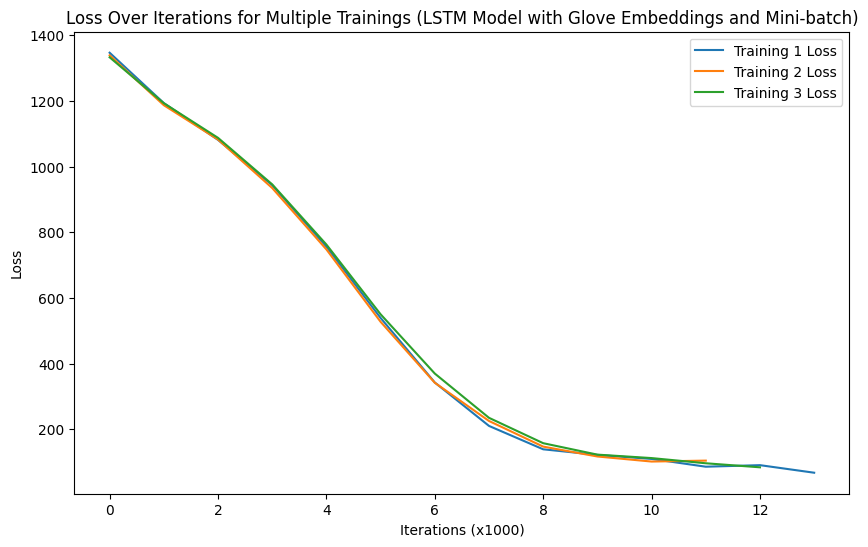

Average Test Accuracy: 0.4649
Test Accuracy Standard Deviation: 0.0025


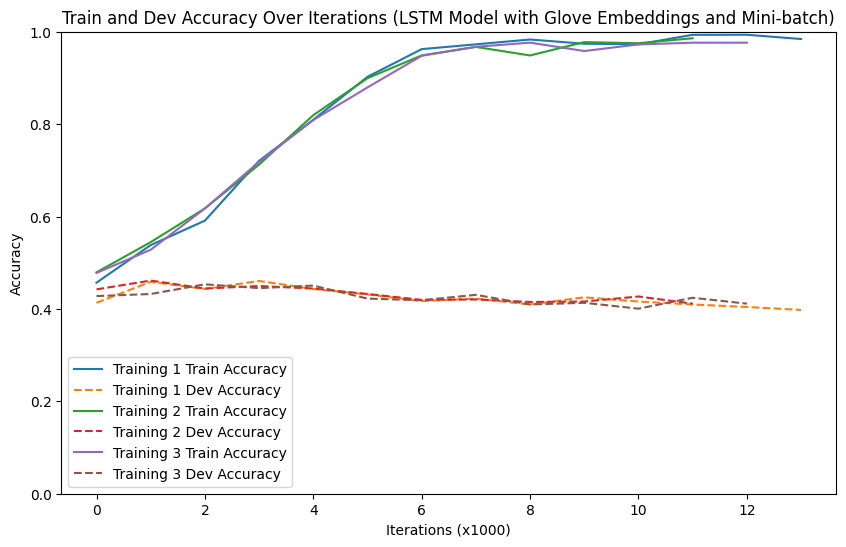

In [90]:
# Aggregate and display results

for i, result in enumerate(results["lstm_glove_mb"]):
    print(f"Training {i+1}:")
    print(f"  Final Test Loss: {result['test_loss']:.4f}")
    print(f"  Final Test Accuracy: {result['test_acc']:.4f}")

# Print average test loss
test_losses = [result["test_loss"] for result in results["lstm_glove_mb"]]
print(f"Average Test Loss: {np.mean(test_losses):.4f}")

# Print standard deviation of test loss
print(f"Test Loss Standard Deviation: {np.std(test_losses):.4f}")

# Plot loss over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["lstm_glove_mb"]):
    plt.plot(result["train_loss"], label=f"Training {i+1} Loss")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Loss")
plt.title("Loss Over Iterations for Multiple Trainings (LSTM Model with Glove Embeddings and Mini-batch)")
plt.legend()
# Save plot
plt.savefig("plots/lstm_glove_mb_loss.png")
plt.show()

# Print average test accuracy
test_accs = [result["test_acc"] for result in results["lstm_glove_mb"]]
print(f"Average Test Accuracy: {np.mean(test_accs):.4f}")

# Print standard deviation of test accuracy
print(f"Test Accuracy Standard Deviation: {np.std(test_accs):.4f}")

# Plot accuracy over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["lstm_glove_mb"]):
    plt.plot(result["train_acc"], label=f"Training {i+1} Train Accuracy")
    plt.plot(result["dev_acc"], label=f"Training {i+1} Dev Accuracy", linestyle="--")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Train and Dev Accuracy Over Iterations (LSTM Model with Glove Embeddings and Mini-batch)")
plt.legend()
# Save plot
plt.savefig("plots/lstm_glove_mb_acc.png")
plt.show()

Fine-tuning word embeddings

In [91]:
# lstm_model = LSTMClassifier(
#     len(v.w2i), 300, 168, len(t2i), v)

# # Now fine-tune your embeddings together with the model
# # NOTE: FOR ROWAN, same thing here, we are finetuning the Glove embeddings, but we could also finetune the word2vec embeddings
# # YOUR CODE HERE
# # Copy pre-trained vectors into embeddings table and enable fine-tuning
# lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
# lstm_model.embed.weight.requires_grad = True  # Enable fine-tuning of embeddings

# print(lstm_model)
# print_parameters(lstm_model)

# lstm_model = lstm_model.to(device)

# batch_size = 25
# optimizer = optim.Adam(lstm_model.parameters(), lr=2e-4)

# lstm_finetune_loss, lstm_finetune_accuracies_dev, lstm_finetune_accuracies_train, lstm_finetune_test_loss, lstm_finetune_test_accuracy = train_model(
#     lstm_model, optimizer, num_iterations=1000,
#     print_every=500, eval_every=100,
#     batch_size=batch_size,
#     batch_fn=get_minibatch,
#     prep_fn=prepare_minibatch,
#     eval_fn=evaluate)

# Train LSTM with fine-tuning

results["lstm_glove_ft"] = []

for i in range(NUM_TRAININGS):
    print(f"Training {i+1}/{NUM_TRAININGS}")
    lstm_model = LSTMClassifier(len(v.w2i), 300, 168, len(t2i), v)
    lstm_model.embed.weight.data.copy_(torch.from_numpy(vectors))
    lstm_model.embed.weight.requires_grad = True
    lstm_model = lstm_model.to(device)
    optimizer = optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = MultiStepLR(optimizer, milestones=[40000, 60000, 70000, 80000, 90000,], gamma=0.5)
    results_iter, model = train_model(
        lstm_model, optimizer, num_iterations=100000,
        print_every=1000, eval_every=1000, scheduler=scheduler,
        batch_fn=get_minibatch, prep_fn=prepare_minibatch, eval_fn=evaluate, batch_size=16)
    
    results["lstm_glove_ft"].append(results_iter)

    # Save model
    path = "models/lstm_glove_ft_{}.pt".format(i+1)
    torch.save(model.state_dict(), path)


Training 1/3
Shuffling training data
Shuffling training data
Iter 1000: loss=1320.9063, time=41.31s
iter 1000: dev acc=0.4133
new highscore
Shuffling training data
Shuffling training data
Iter 2000: loss=895.9072, time=88.72s
iter 2000: dev acc=0.3951
No improvement. Early stopping counter: 1/10
Shuffling training data
Shuffling training data
Iter 3000: loss=512.4675, time=134.64s
iter 3000: dev acc=0.3896
No improvement. Early stopping counter: 2/10
Shuffling training data
Shuffling training data
Iter 4000: loss=246.7845, time=180.07s
iter 4000: dev acc=0.4142
new highscore
Shuffling training data
Shuffling training data
Iter 5000: loss=153.3799, time=225.68s
iter 5000: dev acc=0.3751
No improvement. Early stopping counter: 1/10
Shuffling training data
Shuffling training data
Iter 6000: loss=126.1715, time=271.29s
iter 6000: dev acc=0.3642
No improvement. Early stopping counter: 2/10
Shuffling training data
Shuffling training data
Iter 7000: loss=106.7871, time=316.84s
iter 7000: dev 

/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/1526041850.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


Shuffling training data
best model iter 4000: train acc=0.9658, dev acc=0.4142, test acc=0.4109
Training 2/3
Shuffling training data
Shuffling training data
Iter 1000: loss=1309.4480, time=39.56s
iter 1000: dev acc=0.4178
new highscore
Shuffling training data
Shuffling training data
Iter 2000: loss=891.6754, time=85.08s
iter 2000: dev acc=0.4042
No improvement. Early stopping counter: 1/10
Shuffling training data
Shuffling training data
Iter 3000: loss=504.3451, time=130.50s
iter 3000: dev acc=0.4087
No improvement. Early stopping counter: 2/10
Shuffling training data
Shuffling training data
Iter 4000: loss=222.1155, time=175.84s
iter 4000: dev acc=0.3806
No improvement. Early stopping counter: 3/10
Shuffling training data
Shuffling training data
Iter 5000: loss=156.2521, time=221.35s
iter 5000: dev acc=0.3924
No improvement. Early stopping counter: 4/10
Shuffling training data
Shuffling training data
Iter 6000: loss=135.0652, time=266.44s
iter 6000: dev acc=0.3787
No improvement. Earl

Training 1:
  Final Test Loss: 392.4607
  Final Test Accuracy: 0.4109
Training 2:
  Final Test Loss: 177.2440
  Final Test Accuracy: 0.4348
Training 3:
  Final Test Loss: 175.5371
  Final Test Accuracy: 0.4367
Average Test Loss: 248.4139
Test Loss Standard Deviation: 101.8589


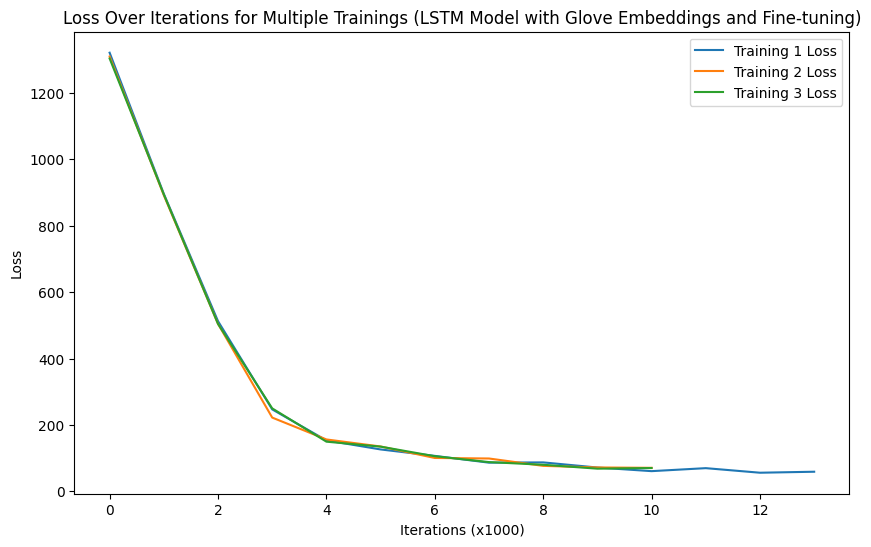

Average Test Accuracy: 0.4275
Test Accuracy Standard Deviation: 0.0118


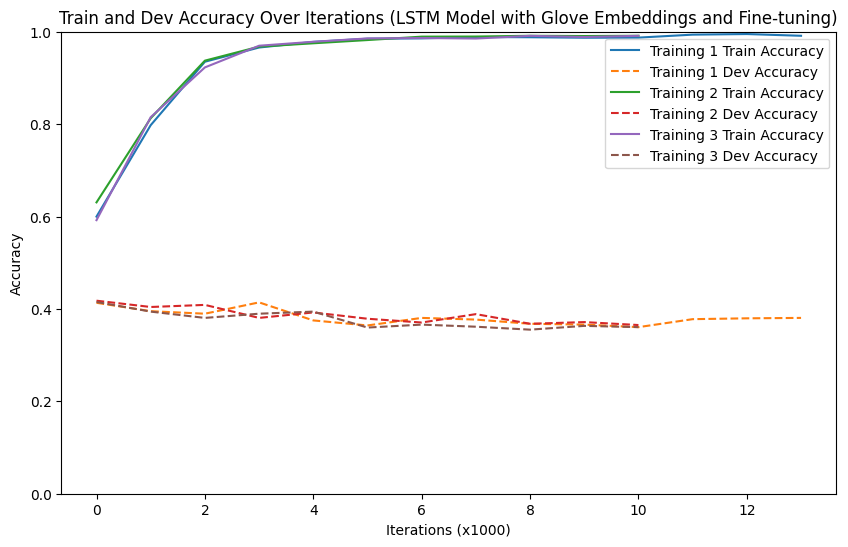

In [92]:
# Aggregate and display results

for i, result in enumerate(results["lstm_glove_ft"]):
    print(f"Training {i+1}:")
    print(f"  Final Test Loss: {result['test_loss']:.4f}")
    print(f"  Final Test Accuracy: {result['test_acc']:.4f}")

# Print average test loss
test_losses = [result["test_loss"] for result in results["lstm_glove_ft"]]
print(f"Average Test Loss: {np.mean(test_losses):.4f}")

# Print standard deviation of test loss
print(f"Test Loss Standard Deviation: {np.std(test_losses):.4f}")

# Plot loss over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["lstm_glove_ft"]):
    plt.plot(result["train_loss"], label=f"Training {i+1} Loss")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Loss")
plt.title("Loss Over Iterations for Multiple Trainings (LSTM Model with Glove Embeddings and Fine-tuning)")
plt.legend()
# Save plot
plt.savefig("plots/lstm_glove_ft_loss.png")
plt.show()

# Print average test accuracy
test_accs = [result["test_acc"] for result in results["lstm_glove_ft"]]
print(f"Average Test Accuracy: {np.mean(test_accs):.4f}")

# Print standard deviation of test accuracy
print(f"Test Accuracy Standard Deviation: {np.std(test_accs):.4f}")

# Plot accuracy over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["lstm_glove_ft"]):
    plt.plot(result["train_acc"], label=f"Training {i+1} Train Accuracy")
    plt.plot(result["dev_acc"], label=f"Training {i+1} Dev Accuracy", linestyle="--")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Train and Dev Accuracy Over Iterations (LSTM Model with Glove Embeddings and Fine-tuning)")
plt.legend()
# Save plot
plt.savefig("plots/lstm_glove_ft_acc.png")
plt.show()


# Tree-LSTM

In the final part of this lab we will exploit the tree structure of the SST data.
Until now we only used the surface tokens, but remember that our data examples include binary trees with a sentiment score at every node.

In particular, we will implement **N-ary Tree-LSTMs** which are described in:

> Kai Sheng Tai, Richard Socher, and Christopher D. Manning. [Improved Semantic Representations From Tree-Structured Long Short-Term Memory Networks](http://aclweb.org/anthology/P/P15/P15-1150.pdf) ACL 2015.

Since our trees are binary (i.e., N=2), we can refer to these as *Binary Tree-LSTMs*. If you study equations (9) to (14) in the paper, you will find that they are not all too different from the original LSTM that you already have.

You should read this paper carefully and make sure that you understand the approach. You will also find our LSTM baseline there.
Note however that Tree-LSTMs were proposed around the same time by two other groups:

> Phong Le and Willem Zuidema. [Compositional distributional semantics with long short term memory](http://anthology.aclweb.org/S/S15/S15-1002.pdf). *SEM 2015.

> Xiaodan Zhu, Parinaz Sobihani,  and Hongyu Guo. [Long short-term memory over recursive structures](http://proceedings.mlr.press/v37/zhub15.pdf). ICML 2015.

It is good scientific practice to cite all three papers in your report.




## Computation

Do you remember the `transitions_from_treestring` function all the way in the beginning of this lab? Every example contains a **transition sequence** produced by this function. Let's look at it again:



In [93]:
ex = next(examplereader("trees/dev.txt"))
print(TreePrettyPrinter(ex.tree))
print("Transitions:")
print(ex.transitions)

              3                                                                     
  ____________|____________________                                                  
 |                                 4                                                
 |        _________________________|______________________________________________   
 |       4                                                                        | 
 |    ___|______________                                                          |  
 |   |                  4                                                         | 
 |   |         _________|__________                                               |  
 |   |        |                    3                                              | 
 |   |        |               _____|______________________                        |  
 |   |        |              |                            4                       | 
 |   |        |              |            ________________|_

Note that the tree is **binary**. Every node has two children, except for pre-terminal nodes.

A tree like this can be described by a sequence of **SHIFT (0)** and **REDUCE (1)** actions.

To construct a tree, we can use the transitions as follows:
- **reverse** the sentence (a list of tokens) and call this the **buffer**
   - the first word is now on top (last in the list), and we would get it when calling pop() on the buffer
- create an empty list and call it the **stack**
- iterate through the transition sequence:
  - if it says SHIFT(0), we pop a word from the buffer, and push it to the stack
  - if it says REDUCE(1), we pop the **top two items** from the stack, and combine them (e.g. with a Tree-LSTM!), creating a new node that we push back on the stack
  
Convince yourself that going through the transition sequence above will result in the tree that you see.
For example, we would start by putting the following words on the stack (by shifting 5 times, starting with `It`):

```
Top of the stack:
-----------------
film
lovely
a
's  
It
```
Now we find a REDUCE in the transition sequence, so we get the top two words (film and lovely), and combine them, so our new stack becomes:
```
Top of the stack:
-----------------
lovely film
a
's  
It
```

We will use this approach when encoding sentences with our Tree-LSTM.
Now, our sentence is a reversed list of word embeddings.
When we shift, we move a word embedding to the stack.
When we reduce, we apply the Tree-LSTM to the top two vectors, and the result is a single vector that we put back on the stack.
After going through the whole transition sequence, we will have the root node on our stack! We can use that to classify the sentence.



## Obtaining the transition sequence



So what goes on in the `transitions_from_treestring` function?

The idea ([explained in this blog post](https://devblogs.nvidia.com/recursive-neural-networks-pytorch/)) is that, if we had a tree, we could traverse through the tree, and every time that we find a node containing only a word, we output a SHIFT.
Every time **after** we have finished visiting the children of a node, we output a REDUCE.
(What is this tree traversal called?)

However, our `transitions_from_treestring` function operates directly on the string representation. It works as follows.

We start with the representation:

```
(3 (2 It) (4 (4 (2 's) (4 (3 (2 a) (4 (3 lovely) (2 film))) (3 (2 with) (4 (3 (3 lovely) (2 performances)) (2 (2 by) (2 (2 (2 Buy) (2 and)) (2 Accorsi))))))) (2 .)))
```

First we remove pre-terminal nodes (and add spaces before closing brackets):

```
(3 It (4 (4 's (4 (3 a (4 lovely film ) ) (3 with (4 (3 lovely performances ) (2 by (2 (2 Buy and )  Accorsi ) ) ) ) ) ) . ) )
```

Then we remove node labels:

```
( It ( ( 's ( ( a ( lovely film ) ) ( with ( ( lovely performances) ( by ( ( Buy and )  Accorsi ) ) ) ) ) ) . ) )
```

Then we remove opening brackets:

```
It 's a lovely film ) ) with lovely performances ) by Buy and ) Accorsi ) ) ) ) ) ) . ) )
```

Now we replace words by S (for SHIFT), and closing brackets by R (for REDUCE):

```
S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1
```

Et voilà. We just obtained the transition sequence!

In [94]:
# for comparison
seq = ex.transitions
s = " ".join(["S" if t == 0 else "R" for t in seq])
print(s)
print(" ".join(map(str, seq)))

S S S S S R R S S S R S S S R S R R R R R R S R R
0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1


## Coding the Tree-LSTM

The code below contains a Binary Tree-LSTM cell.
It is used in the TreeLSTM class below it, which in turn is used in the TreeLSTMClassifier.
The job of the TreeLSTM class is to encode a complete sentence and return the root node.
The job of the TreeLSTMCell is to return a new state when provided with two children (a reduce action). By repeatedly calling the TreeLSTMCell, the TreeLSTM will encode a sentence. This can be done for multiple sentences at the same time.


#### Exercise
Check the `forward` function and complete the Tree-LSTM formulas.
You can see that we defined a large linear layer for you, that projects the *concatenation* of the left and right child into the input gate, left forget gate, right forget gate, candidate, and output gate.

In [95]:
class TreeLSTMCell(nn.Module):
  """A Binary Tree LSTM cell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTMCell, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias

    self.reduce_layer = nn.Linear(2 * hidden_size, 5 * hidden_size)
    self.dropout_layer = nn.Dropout(p=0.25)

    self.reset_parameters()

  def reset_parameters(self):
    """This is PyTorch's default initialization method"""
    stdv = 1.0 / math.sqrt(self.hidden_size)
    for weight in self.parameters():
      weight.data.uniform_(-stdv, stdv)

  def forward(self, hx_l, hx_r, mask=None):
    """
    hx_l is ((batch, hidden_size), (batch, hidden_size))
    hx_r is ((batch, hidden_size), (batch, hidden_size))
    """
    prev_h_l, prev_c_l = hx_l  # left child
    prev_h_r, prev_c_r = hx_r  # right child

    B = prev_h_l.size(0)

    # we concatenate the left and right children
    # you can also project from them separately and then sum
    children = torch.cat([prev_h_l, prev_h_r], dim=1)

    # project the combined children into a 5D tensor for i,fl,fr,g,o
    # this is done for speed, and you could also do it separately
    proj = self.reduce_layer(children)  # shape: B x 5D

    # each shape: B x D
    i, f_l, f_r, g, o = torch.chunk(proj, 5, dim=-1)

    # main Tree LSTM computation

    # YOUR CODE HERE
    # You only need to complete the commented lines below.

    # The shape of each of these is [batch_size, hidden_size]

    i = torch.sigmoid(i)        # Input gate
    f_l = torch.sigmoid(f_l)    # Left forget gate
    f_r = torch.sigmoid(f_r)    # Right forget gate
    g = torch.tanh(g)           # Cell candidate
    o = torch.sigmoid(o)        # Output gate

    c = i * g + f_l * prev_c_l + f_r * prev_c_r
    h = o * torch.tanh(c)

    return h, c

  def __repr__(self):
    return "{}({:d}, {:d})".format(
        self.__class__.__name__, self.input_size, self.hidden_size)

## Explanation of the TreeLSTM class


The code below contains the TreeLSTM class, which implements everything we need in order to encode a sentence from word embeddings. The calculations are the same as in the paper, implemented such that the class `TreeLSTMCell` above is as general as possible and only takes two children to reduce them into a parent.


**Initialize $\mathbf{h}$ and $\mathbf{c}$ outside of the cell for the leaves**

At the leaves of each tree the children nodes are **empty**, whereas in higher levels the nodes are binary tree nodes that *do* have a left and right child (but no input $x$). By initializing the leaf nodes outside of the cell class (`TreeLSTMCell`), we avoid if-else statements in the forward pass.

The `TreeLSTM` class (among other things) pre-calculates an initial $h$ and $c$ for every word in the sentence. Since the initial left and right child are 0, the only calculations we need to do are based on $x$, and we can drop the forget gate calculation (`prev_c_l` and `prev_c_r` are zero). The calculations we do in order to initalize $h$ and $c$ are then:

$$
c_1 =  W^{(u)}x_1 \\
o_1 = \sigma (W^{(i)}x_1) \\
h_1 = o_1 \odot \text{tanh}(c_1)$$
*NB: note that these equations are chosen as initializations of $c$ and $h$, other initializations are possible and might work equally well.*

**Sentence Representations**

All our leaf nodes are now initialized, so we can start processing the sentence in its tree form. Each sentence is represented by a buffer (initially a list with a concatenation of $[h_1, c_1]$ for every word in the reversed sentence), a stack (initially an empty list) and a transition sequence. To encode our sentence, we construct the tree from its transition sequence as explained earlier.

*A short example that constructs a tree:*

We loop over the time dimension of the batched transition sequences (i.e. row by row), which contain values of 0's, 1's and 2's (representing SHIFT, REDUCE and padding respectively). If we have a batch of size 2 where the first example has a transition sequence given by [0, 0, 1, 0, 0, 0, 1] and the second by [0, 0, 1, 0, 0, 1], our transition batch will be given by the following two-dimensional numpy array:

$$
\text{transitions} =
\begin{pmatrix}
0 & 0\\
0 & 0\\
1 & 1\\
0 & 0\\
0 & 0\\
0 & 1\\
1 & 2
\end{pmatrix}
$$
The inner loop (`for transition, buffer, stack in zip(t_batch, buffers, stacks)`) goes over each example in the batch and updates its buffer and stack. The nested loop for this example will then do roughy the following:

```
Time = 0:  t_batch = [0, 0], the inner loop performs 2 SHIFTs.

Time = 1:  t_batch = [0, 0], ".."

Time = 2:  t_batch = [1, 1], causing the inner loop to fill the list child_l and child_r for both examples in the batch. Now the statement if child_l will return True, triggering a REDUCE action to be performed by our Tree LSTM cell with a batch size of 2.

Time = 3:  t_batch = [0, 0], "..".

Time = 4:  t_batch = [0, 0], ".."

Time = 5:  t_batch = [0, 1], one SHIFT will be done and another REDUCE action will be performed by our Tree LSTM, this time of batch size 1.  

Time = 6:  t_batch = [1, 2], triggering another REDUCE action with batch size 1.
```
*NB: note that this was an artificial example for the purpose of demonstrating parts of the code, the transition sequences do not necessarily represent actual trees.*

**Batching and Unbatching**

Within the body of the outer loop over time, we use the functions for batching and unbatching.

*Batching*

Before passing two lists of children to the reduce layer (an instance of `TreeLSTMCell`), we batch the children as they are at this point a list of tensors of variable length based on how many REDUCE actions there are to perform at a certain time step across the batch (let's call the length `L`). To do an efficient forward pass we want to transform the list to a pair of tensors of shape `([L, D], [L, D])`, which the function `batch` achieves.

*Unbatching*

In the same line where we batched the children, we unbatch the output of the forward pass to become a list of states of length `L` again. We do this because we need to loop over each example's transition at the current time step and push the children that are reduced into a parent to the stack.

*The batch and unbatch functions let us switch between the "PyTorch world" (Tensors) and the Python world (easy to manipulate lists).*


In [96]:
# Helper functions for batching and unbatching states
# For speed we want to combine computations by batching, but
# for processing logic we want to turn the output into lists again
# to easily manipulate.

def batch(states):
  """
  Turns a list of states into a single tensor for fast processing.
  This function also chunks (splits) each state into a (h, c) pair"""
  return torch.cat(states, 0).chunk(2, 1)

def unbatch(state):
  """
  Turns a tensor back into a list of states.
  First, (h, c) are merged into a single state.
  Then the result is split into a list of sentences.
  """
  return torch.split(torch.cat(state, 1), 1, 0)

Take some time to understand the class below, having read the explanation above.

In [113]:
class TreeLSTM(nn.Module):
  """Encodes a sentence using a TreeLSTMCell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(TreeLSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.reduce = TreeLSTMCell(input_size, hidden_size)

    # project word to initial c
    self.proj_x = nn.Linear(input_size, hidden_size)
    self.proj_x_gate = nn.Linear(input_size, hidden_size)

    self.buffers_dropout = nn.Dropout(p=0.5)

  def forward(self, x, transitions):
    """
    WARNING: assuming x is reversed!
    :param x: word embeddings [B, T, E]
    :param transitions: [2T-1, B]
    :return: root states
    """

    B = x.size(0)  # batch size
    T = x.size(1)  # time

    # compute an initial c and h for each word
    # Note: this corresponds to input x in the Tai et al. Tree LSTM paper.
    # We do not handle input x in the TreeLSTMCell itself.
    buffers_c = self.proj_x(x)
    buffers_h = buffers_c.tanh()
    buffers_h_gate = self.proj_x_gate(x).sigmoid()
    buffers_h = buffers_h_gate * buffers_h

    # concatenate h and c for each word
    buffers = torch.cat([buffers_h, buffers_c], dim=-1)

    D = buffers.size(-1) // 2

    # we turn buffers into a list of stacks (1 stack for each sentence)
    # first we split buffers so that it is a list of sentences (length B)
    # then we split each sentence to be a list of word vectors
    buffers = buffers.split(1, dim=0)  # Bx[T, 2D]
    buffers = [list(b.squeeze(0).split(1, dim=0)) for b in buffers]  # BxTx[2D]

    # create B empty stacks
    stacks = [[] for _ in buffers]

    # t_batch holds 1 transition for each sentence
    for t_batch in transitions:

      child_l = []  # contains the left child for each sentence with reduce action
      child_r = []  # contains the corresponding right child

      # iterate over sentences in the batch
      # each has a transition t, a buffer and a stack
      for transition, buffer, stack in zip(t_batch, buffers, stacks):
        if transition == SHIFT:
          stack.append(buffer.pop())
        elif transition == REDUCE:
          assert len(stack) >= 2, \
            "Stack too small! Should not happen with valid transition sequences"
          child_r.append(stack.pop())  # right child is on top
          child_l.append(stack.pop())

      # if there are sentences with reduce transition, perform them batched
      if child_l:
        reduced = iter(unbatch(self.reduce(batch(child_l), batch(child_r))))
        for transition, stack in zip(t_batch, stacks):
          if transition == REDUCE:
            stack.append(next(reduced))

    final = [stack.pop().chunk(2, -1)[0] for stack in stacks]
    final = torch.cat(final, dim=0)  # tensor [B, D]

    return final

Just like the LSTM before, we will need an extra class that does the classifications.

In [ ]:
class TreeLSTMClassifier(nn.Module):
  """Encodes sentence with a TreeLSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(TreeLSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.treelstm = TreeLSTM(embedding_dim, hidden_dim)
    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(hidden_dim, output_dim, bias=True)
    )

  def forward(self, x):

    # x is a pair here of words and transitions; we unpack it here.
    # x is batch-major: [B, T], transitions is time major [2T-1, B]
    x, transitions = x
    emb = self.embed(x)

    # we use the root/top state of the Tree LSTM to classify the sentence
    root_states = self.treelstm(emb, transitions)

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(root_states)
    return logits

## Special `prepare` function for Tree-LSTM

We need yet another `prepare` function. For our implementation, sentences need to be *reversed*. We will do that here.

In [99]:
def prepare_treelstm_minibatch(mb, vocab):
  """
  Returns sentences reversed (last word first)
  Returns transitions together with the sentences.
  """
  batch_size = len(mb)
  maxlen = max([len(ex.tokens) for ex in mb])

  # vocab returns 0 if the word is not there
  # NOTE: reversed sequence!
  x = [pad([vocab.w2i.get(t, 0) for t in ex.tokens], maxlen)[::-1] for ex in mb]

  x = torch.LongTensor(x)
  x = x.to(device)

  y = [ex.label for ex in mb]
  y = torch.LongTensor(y)
  y = y.to(device)

  maxlen_t = max([len(ex.transitions) for ex in mb])
  transitions = [pad(ex.transitions, maxlen_t, pad_value=2) for ex in mb]
  transitions = np.array(transitions)
  transitions = transitions.T  # time-major

  return (x, transitions), y

## Training

In [100]:
# Now let's train the Tree LSTM!

# tree_model = TreeLSTMClassifier(
#     len(v.w2i), 300, 150, len(t2i), v)

# with torch.no_grad():
#   tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
#   tree_model.embed.weight.requires_grad = False

# def do_train(model):

#   print(model)
#   print_parameters(model)

#   model = model.to(device)

#   optimizer = optim.Adam(model.parameters(), lr=2e-4)

#   return train_model(
#       model, optimizer, num_iterations=1000,
#       print_every=250, eval_every=250,
#       prep_fn=prepare_treelstm_minibatch,
#       eval_fn=evaluate,
#       batch_fn=get_minibatch,
#       batch_size=25, eval_batch_size=25)

# results = do_train(tree_model)

# Train Tree LSTM

results["treelstm_glove"] = []

for i in range(NUM_TRAININGS):
    print(f"Training {i+1}/{NUM_TRAININGS}")
    tree_model = TreeLSTMClassifier(len(v.w2i), 300, 150, len(t2i), v)
    tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
    tree_model.embed.weight.requires_grad = False
    tree_model = tree_model.to(device)
    optimizer = optim.Adam(tree_model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = MultiStepLR(optimizer, milestones=[40000, 60000, 70000, 80000, 90000,], gamma=0.5)
    results_iter, model = train_model(
        tree_model, optimizer, num_iterations=100000,
        print_every=1000, eval_every=1000, scheduler=scheduler,
        prep_fn=prepare_treelstm_minibatch, eval_fn=evaluate, batch_fn=get_minibatch, batch_size=16)
    
    results["treelstm_glove"].append(results_iter)

    # Save model
    path = "models/treelstm_glove_{}.pt".format(i+1)
    torch.save(model.state_dict(), path)

Training 1/3
Shuffling training data
Shuffling training data
Iter 1000: loss=1311.1283, time=88.76s
iter 1000: dev acc=0.4378
new highscore
Shuffling training data
Shuffling training data
Iter 2000: loss=1178.9581, time=189.28s
iter 2000: dev acc=0.4559
new highscore
Shuffling training data
Shuffling training data
Iter 3000: loss=1082.1472, time=288.01s
iter 3000: dev acc=0.4523
No improvement. Early stopping counter: 1/10
Shuffling training data
Shuffling training data
Iter 4000: loss=967.1295, time=385.34s
iter 4000: dev acc=0.4405
No improvement. Early stopping counter: 2/10
Shuffling training data
Shuffling training data
Iter 5000: loss=842.2514, time=483.41s
iter 5000: dev acc=0.4305
No improvement. Early stopping counter: 3/10
Shuffling training data
Shuffling training data
Iter 6000: loss=675.5667, time=582.57s
iter 6000: dev acc=0.4332
No improvement. Early stopping counter: 4/10
Shuffling training data
Shuffling training data
Iter 7000: loss=510.5590, time=682.64s
iter 7000: d

/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/1526041850.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


Shuffling training data
best model iter 2000: train acc=0.5328, dev acc=0.4559, test acc=0.4842
Training 2/3
Shuffling training data
Shuffling training data
Iter 1000: loss=1307.5121, time=84.39s
iter 1000: dev acc=0.4487
new highscore
Shuffling training data
Shuffling training data
Iter 2000: loss=1174.7169, time=182.79s
iter 2000: dev acc=0.4523
new highscore
Shuffling training data
Shuffling training data
Iter 3000: loss=1062.5445, time=281.79s
iter 3000: dev acc=0.4214
No improvement. Early stopping counter: 1/10
Shuffling training data
Shuffling training data
Iter 4000: loss=963.7864, time=381.19s
iter 4000: dev acc=0.4441
No improvement. Early stopping counter: 2/10
Shuffling training data
Shuffling training data
Iter 5000: loss=818.2930, time=479.00s
iter 5000: dev acc=0.4169
No improvement. Early stopping counter: 3/10
Shuffling training data
Shuffling training data
Iter 6000: loss=663.5726, time=576.67s
iter 6000: dev acc=0.4296
No improvement. Early stopping counter: 4/10
Shu

Training 1:
  Final Test Loss: 163.2422
  Final Test Accuracy: 0.4842
Training 2:
  Final Test Loss: 166.5014
  Final Test Accuracy: 0.4787
Training 3:
  Final Test Loss: 165.1343
  Final Test Accuracy: 0.4774
Average Test Loss: 164.9593
Test Loss Standard Deviation: 1.3363


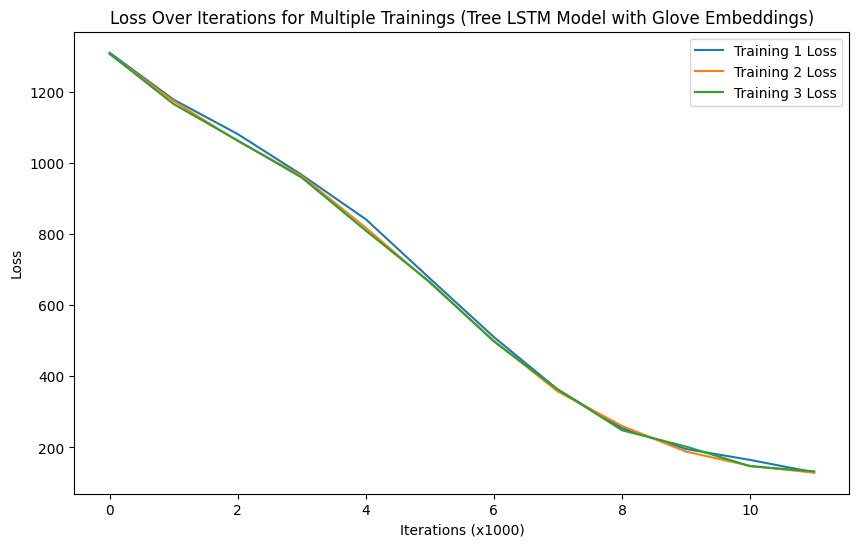

Average Test Accuracy: 0.4801
Test Accuracy Standard Deviation: 0.0029


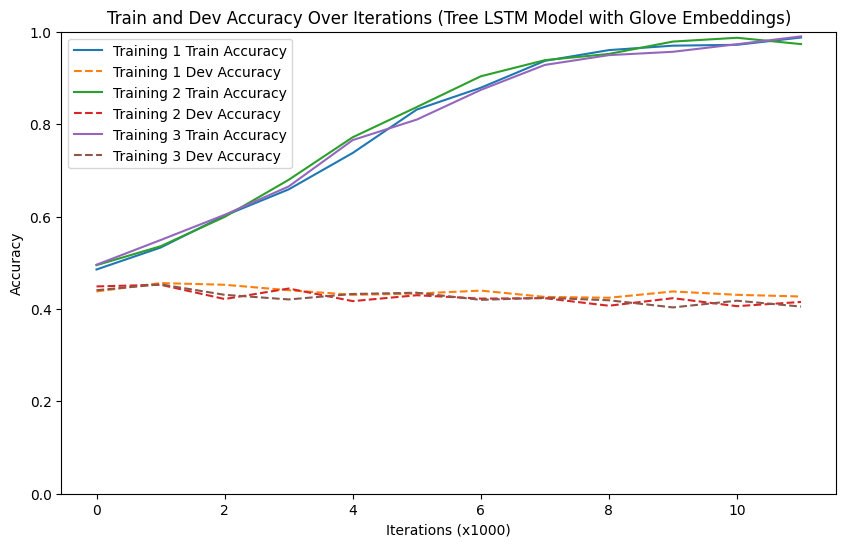

In [101]:
# Aggregate and display results

for i, result in enumerate(results["treelstm_glove"]):
    print(f"Training {i+1}:")
    print(f"  Final Test Loss: {result['test_loss']:.4f}")
    print(f"  Final Test Accuracy: {result['test_acc']:.4f}")

# Print average test loss
test_losses = [result["test_loss"] for result in results["treelstm_glove"]]
print(f"Average Test Loss: {np.mean(test_losses):.4f}")

# Print standard deviation of test loss
print(f"Test Loss Standard Deviation: {np.std(test_losses):.4f}")

# Plot loss over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["treelstm_glove"]):
    plt.plot(result["train_loss"], label=f"Training {i+1} Loss")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Loss")
plt.title("Loss Over Iterations for Multiple Trainings (Tree LSTM Model with Glove Embeddings)")
plt.legend()
# Save plot
plt.savefig("plots/treelstm_glove_loss.png")
plt.show()

# Print average test accuracy
test_accs = [result["test_acc"] for result in results["treelstm_glove"]]
print(f"Average Test Accuracy: {np.mean(test_accs):.4f}")

# Print standard deviation of test accuracy
print(f"Test Accuracy Standard Deviation: {np.std(test_accs):.4f}")

# Plot accuracy over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["treelstm_glove"]):
    plt.plot(result["train_acc"], label=f"Training {i+1} Train Accuracy")
    plt.plot(result["dev_acc"], label=f"Training {i+1} Dev Accuracy", linestyle="--")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Train and Dev Accuracy Over Iterations (Tree LSTM Model with Glove Embeddings)")
plt.legend()
# Save plot
plt.savefig("plots/treelstm_glove_acc.png")
plt.show()

In [106]:
import pandas as pd
from IPython.display import display

# Convert results dictionary into a tabular format with only test metrics
rows = []
for model_name, iterations in results.items():
    for i, metrics in enumerate(iterations):
        row = {
            "Model": model_name,
            "Iteration": i + 1,
            "Test Loss": metrics["test_loss"],
            "Test Accuracy": metrics["test_acc"]
        }
        rows.append(row)

# Create a DataFrame
df = pd.DataFrame(rows)

# Display the DataFrame in a notebook
display(df)

# Save the DataFrame as a CSV file
df.to_csv("results.csv", index=False)

,Model,Iteration,Test Loss,Test Accuracy
0,bow_model,1,4965.220076,0.280543
1,bow_model,2,3486.438569,0.372851
2,bow_model,3,3503.533969,0.380543
3,cbow_model,1,4245.535458,0.371493
4,cbow_model,2,4392.334096,0.355656
5,cbow_model,3,4183.766230,0.360181
6,deep_cbow_model,1,3165.377428,0.368778
7,deep_cbow_model,2,3325.909303,0.387330
8,deep_cbow_model,3,3179.830504,0.382353
9,pt_glove_deep_cbow_model,1,2918.472853,0.410860


In [107]:
# Create a summary table for average and standard deviation of test metrics
summary_rows = []
for model_name, iterations in results.items():
    test_losses = [metrics["test_loss"] for metrics in iterations]
    test_accuracies = [metrics["test_acc"] for metrics in iterations]
    
    row = {
        "Model": model_name,
        "Avg Test Loss": round(sum(test_losses) / len(test_losses), 4),
        "Std Test Loss": round(pd.Series(test_losses).std(), 4),
        "Avg Test Accuracy": round(sum(test_accuracies) / len(test_accuracies), 4),
        "Std Test Accuracy": round(pd.Series(test_accuracies).std(), 4),
    }
    summary_rows.append(row)

# Create a DataFrame for the summary
summary_df = pd.DataFrame(summary_rows)

# Display the summary table
display(summary_df)

# Save the summary table to a CSV file
summary_df.to_csv("results_summary.csv", index=False)

,Model,Avg Test Loss,Std Test Loss,Avg Test Accuracy,Std Test Accuracy
0,bow_model,3985.0642,848.8829,0.3446,0.0556
1,cbow_model,4273.8786,107.1337,0.3624,0.0082
2,deep_cbow_model,3223.7057,88.8054,0.3795,0.0096
3,pt_glove_deep_cbow_model,2927.2123,23.6517,0.4183,0.0098
4,pt_word2vec_deep_cbow_model,2890.0174,61.5718,0.4321,0.0096
5,lstm_glove,2647.8802,23.4715,0.4751,0.0063
6,lstm_glove_mb,173.9114,8.9448,0.4649,0.0030
7,lstm_glove_ft,248.4139,124.7511,0.4275,0.0144
8,treelstm_glove,164.9593,1.6366,0.4801,0.0036


## RQ 1: How important is word order for this task?

In [ ]:
#(R) implementing the word shuffling code

def shuffle_dataset(data, seed = 0):
    """Shuffle the word order of the tokens in the dataset."""
    random.seed(seed)
    shuffled_data = []
    for example in data:
        shuffled_tokens = example.tokens[:]
        random.shuffle(shuffled_tokens)
        #to keep some tree associated with data we remove the tree structure of the original sentence and make a simple sentence tree
        shuffled_tree = Tree.fromstring(f"(S {' '.join(shuffled_tokens)})")
        shuffled_example = Example(
            tokens=shuffled_tokens,
            tree=shuffled_tree,
            label=example.label,
            transitions=example.transitions
        )
        shuffled_data.append(shuffled_example)
    
    return shuffled_data

shuffled_train_data = shuffle_dataset(train_data)


#(R1) script to turn all tree structures into sentence tree
def tree_chopper(data):
    chopped_data=[]
    for example in data:
        chopped_tokens = example.tokens[:]
        chopped_tree =  Tree.fromstring(f"(S {' '.join(chopped_tokens)})")
        chopped_example = Example(tokens=chopped_tokens, tree=chopped_tree, label = example.label, transitions = example.transitions)
        chopped_data.append(chopped_example)
    return chopped_data

chopped_train_data = tree_chopper(train_data)
#(R2) selecting only certain sentence lengths
def sentence_length_filter(data, n, k):
    filtered_data = []
    for example in data:
        l = len(example.tokens[:])
        if l>=n and l<=k:
            filtered_data.append(example)
    return filtered_data

filtered_data= sentence_length_filter(train_data,5,7)

## RQ 2: Does the tree structure help to get a better accuracy?

## RQ 3: How does performance depend on the sentence length? Compare the various models. Is there a model that does better on longer sentences? If so, why?

## RQ 4: Do you get better performance if you supervise the sentiment **at each node in the tree**? You can extract more training examples by treating every node in each tree as a separate tree. You will need to write a function that extracts all subtrees given a treestring.

In [145]:
import copy


def extract_nltk_subtrees_by_leaf_count(tree, min_leaf_count=1):
    """
    Extract all subtrees from an NLTK tree with at least a specified minimum number of leaf nodes.
    
    Args:
        tree (Tree): The NLTK tree object.
        min_leaf_count (int): Minimum number of leaf nodes in a subtree.
        
    Returns:
        list[Tree]: A list of NLTK Tree objects meeting the minimum leaf count criteria.
    """
    subtrees = []

    def count_leaf_nodes(subtree):
        """Helper function to count the number of leaf nodes in an NLTK tree."""
        return len([n for n in subtree.leaves()])


    for subtree in tree.subtrees():
        if count_leaf_nodes(subtree) >= min_leaf_count:
            subtrees.append(subtree)
    
    return subtrees

def examplecreater(s, lower=False):
  """Returns all examples in a file one by one."""
  tokens = tokens_from_treestring(str(s))
  tree = s  
  label = int(str(s)[1])
  trans = transitions_from_treestring(str(s))
  return Example(tokens=tokens, tree=tree, label=label, transitions=trans)

def transitions_from_treestring(s):
    s = re.sub("\n", "", s)
    s = re.sub("\([0-5] ([^)]+)\)", "0", s)
    s = re.sub("\)", " )", s)
    s = re.sub("\([0-4] ", "", s)
    s = re.sub("\([0-4] ", "", s)
    s = re.sub("\)", "1", s)
    return list(map(int, s.split()))

enlarged_train_data = copy.deepcopy(train_data)

for example in train_data:

  # Extract subtrees with at least 3 nodes
  subtrees = extract_nltk_subtrees_by_leaf_count(example.tree, min_leaf_count=2)

  for idx, subtree in enumerate(subtrees, 1):
      enlarged_train_data.append(examplecreater(subtree))

<>:38: SyntaxWarning: invalid escape sequence '\('
<>:39: SyntaxWarning: invalid escape sequence '\)'
<>:40: SyntaxWarning: invalid escape sequence '\('
<>:41: SyntaxWarning: invalid escape sequence '\('
<>:42: SyntaxWarning: invalid escape sequence '\)'
<>:38: SyntaxWarning: invalid escape sequence '\('
<>:39: SyntaxWarning: invalid escape sequence '\)'
<>:40: SyntaxWarning: invalid escape sequence '\('
<>:41: SyntaxWarning: invalid escape sequence '\('
<>:42: SyntaxWarning: invalid escape sequence '\)'
/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/2457826138.py:38: SyntaxWarning: invalid escape sequence '\('
  s = re.sub("\([0-5] ([^)]+)\)", "0", s)
/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/2457826138.py:39: SyntaxWarning: invalid escape sequence '\)'
  s = re.sub("\)", " )", s)
/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/2457826138.py:40: SyntaxWarning: invalid escape sequence '\('
  s = re.sub("\([0-4] ", "", s)
/var/fo

100%|██████████| 20/20 [03:44<00:00, 11.24s/it]


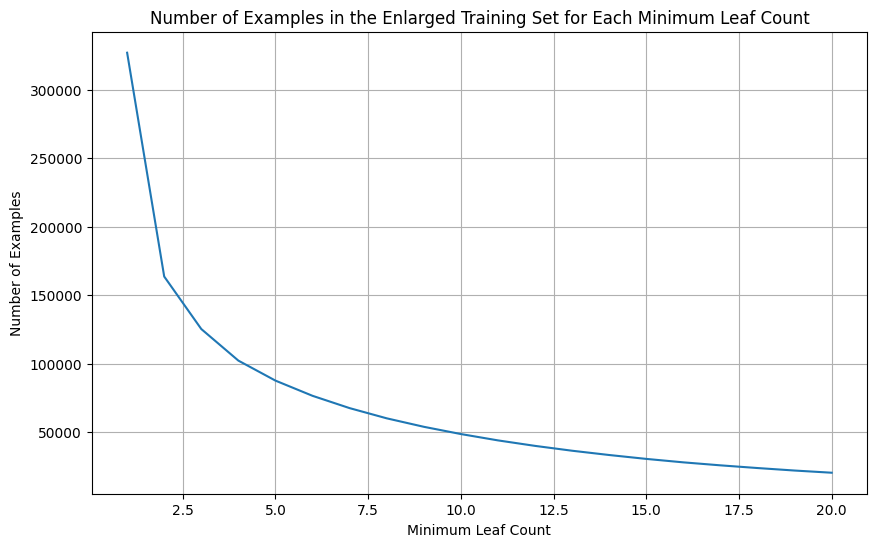

In [144]:
train_sizes =[]
from tqdm import tqdm
for i in tqdm(range(20)):
    min_leaf_count = i + 1

    # Extract subtrees with at least min_leaf_count nodes
    enlarged_train_data = copy.deepcopy(train_data)

    for example in train_data:
        subtrees = extract_nltk_subtrees_by_leaf_count(example.tree, min_leaf_count=min_leaf_count)

        for subtree in subtrees:
            enlarged_train_data.append(examplecreater(subtree))

    train_sizes.append(len(enlarged_train_data))

# Plot the number of examples in the enlarged training set for each minimum leaf count
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_sizes)
plt.xlabel("Minimum Leaf Count")
plt.ylabel("Number of Examples")
plt.title("Number of Examples in the Enlarged Training Set for Each Minimum Leaf Count")
plt.grid()
plt.show()

In [146]:
print(f"Size of the original training data: {len(train_data)}")
print(f"Size of the enlarged training data: {len(enlarged_train_data)}")

Size of the original training data: 8544
Size of the enlarged training data: 163566


In [149]:
# Train Tree LSTM with enlarged dataset

results["treelstm_glove_enlarged"] = []

for i in range(NUM_TRAININGS):
    print(f"Training {i+1}/{NUM_TRAININGS}")
    tree_model = TreeLSTMClassifier(len(v.w2i), 300, 150, len(t2i), v)
    tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
    tree_model.embed.weight.requires_grad = False
    tree_model = tree_model.to(device)
    optimizer = optim.Adam(tree_model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = MultiStepLR(optimizer, milestones=[5000, 10000, 15000, 20000, 25000,], gamma=0.5)
    # Use the enlarged dataset
    results_iter, model = train_model(
        tree_model, optimizer, num_iterations=100000,
        print_every=1000, eval_every=1000, scheduler=scheduler,
        prep_fn=prepare_treelstm_minibatch, eval_fn=evaluate, batch_fn=get_minibatch, batch_size=16,
        train_data=enlarged_train_data)
    
    results["treelstm_glove_enlarged"].append(results_iter)

    # Save model
    path = "models/treelstm_glove_enlarged_{}.pt".format(i+1)

    torch.save(model.state_dict(), path)

Training 1/3
Shuffling training data
Iter 1000: loss=1069.6783, time=68.45s
iter 1000: dev acc=0.4360
new highscore
Iter 2000: loss=991.5499, time=339.97s
iter 2000: dev acc=0.4278
No improvement. Early stopping counter: 1/10
Iter 3000: loss=958.8104, time=614.15s
iter 3000: dev acc=0.4423
new highscore
Iter 4000: loss=954.6289, time=888.54s
iter 4000: dev acc=0.4296
No improvement. Early stopping counter: 1/10
Iter 5000: loss=946.0593, time=1164.58s
iter 5000: dev acc=0.4369
No improvement. Early stopping counter: 2/10
Iter 6000: loss=933.5285, time=1434.64s
iter 6000: dev acc=0.4496
new highscore
Iter 7000: loss=934.4843, time=1705.10s
iter 7000: dev acc=0.4632
new highscore
Iter 8000: loss=917.9248, time=1981.12s
iter 8000: dev acc=0.4505
No improvement. Early stopping counter: 1/10
Iter 9000: loss=921.9421, time=2259.32s
iter 9000: dev acc=0.4605
No improvement. Early stopping counter: 2/10
Iter 10000: loss=927.1656, time=2536.54s
iter 10000: dev acc=0.4559
No improvement. Early st

/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/4039746191.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


Shuffling training data
best model iter 21000: train acc=0.6353, dev acc=0.4777, test acc=0.4765
Training 2/3
Shuffling training data
Iter 1000: loss=1055.5713, time=67.63s
iter 1000: dev acc=0.4387
new highscore
Iter 2000: loss=979.0591, time=341.92s
iter 2000: dev acc=0.4505
new highscore
Iter 3000: loss=958.2118, time=613.87s
iter 3000: dev acc=0.4251
No improvement. Early stopping counter: 1/10
Iter 4000: loss=957.4391, time=885.70s
iter 4000: dev acc=0.4460
No improvement. Early stopping counter: 2/10
Iter 5000: loss=954.6499, time=1156.52s
iter 5000: dev acc=0.4505
No improvement. Early stopping counter: 3/10
Iter 6000: loss=942.7730, time=1426.86s
iter 6000: dev acc=0.4423
No improvement. Early stopping counter: 4/10
Iter 7000: loss=928.3645, time=1699.51s
iter 7000: dev acc=0.4541
new highscore
Iter 8000: loss=922.0467, time=1969.40s
iter 8000: dev acc=0.4614
new highscore
Iter 9000: loss=927.9181, time=2239.25s
iter 9000: dev acc=0.4687
new highscore
Iter 10000: loss=922.7450,

Training 1:
  Final Test Loss: 162.6103
  Final Test Accuracy: 0.4765
Training 2:
  Final Test Loss: 165.1252
  Final Test Accuracy: 0.4706
Training 3:
  Final Test Loss: 164.0355
  Final Test Accuracy: 0.4643
Average Test Loss: 163.9236
Test Loss Standard Deviation: 1.0297


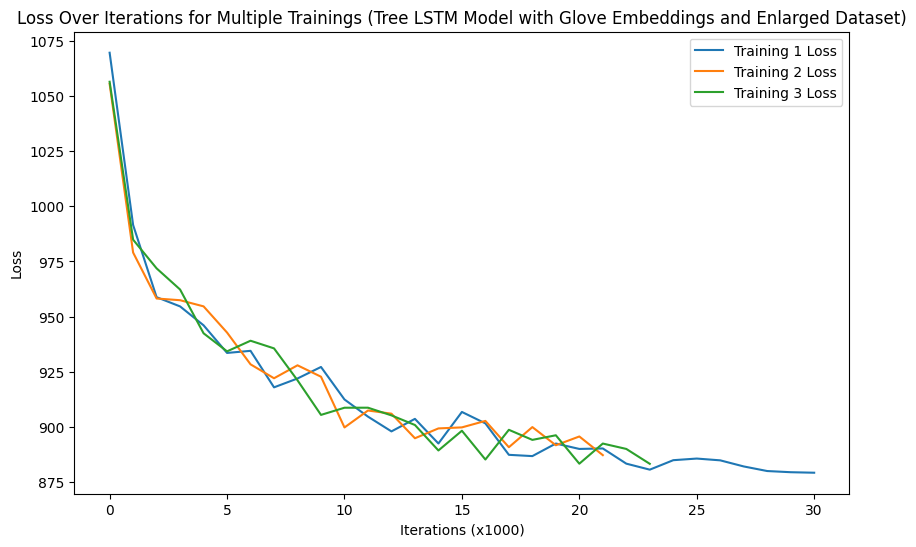

Average Test Accuracy: 0.4704
Test Accuracy Standard Deviation: 0.0050


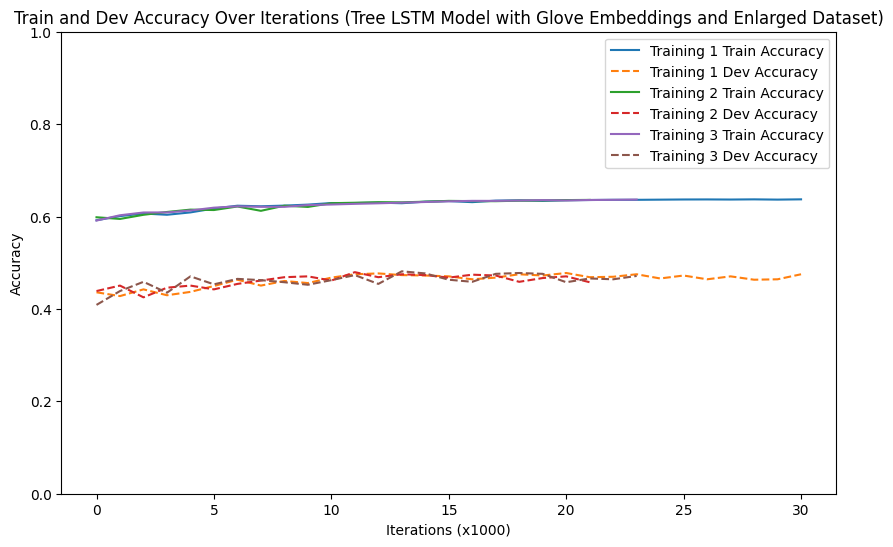

In [150]:
# Aggregate and display results

for i, result in enumerate(results["treelstm_glove_enlarged"]):
    print(f"Training {i+1}:")
    print(f"  Final Test Loss: {result['test_loss']:.4f}")
    print(f"  Final Test Accuracy: {result['test_acc']:.4f}")

# Print average test loss
test_losses = [result["test_loss"] for result in results["treelstm_glove_enlarged"]]
print(f"Average Test Loss: {np.mean(test_losses):.4f}")

# Print standard deviation of test loss
print(f"Test Loss Standard Deviation: {np.std(test_losses):.4f}")

# Plot loss over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["treelstm_glove_enlarged"]):
    plt.plot(result["train_loss"], label=f"Training {i+1} Loss")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Loss")
plt.title("Loss Over Iterations for Multiple Trainings (Tree LSTM Model with Glove Embeddings and Enlarged Dataset)")
plt.legend()
# Save plot
plt.savefig("plots/treelstm_glove_enlarged_loss.png")
plt.show()

# Print average test accuracy
test_accs = [result["test_acc"] for result in results["treelstm_glove_enlarged"]]
print(f"Average Test Accuracy: {np.mean(test_accs):.4f}")

# Print standard deviation of test accuracy
print(f"Test Accuracy Standard Deviation: {np.std(test_accs):.4f}")

# Plot accuracy over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["treelstm_glove_enlarged"]):
    plt.plot(result["train_acc"], label=f"Training {i+1} Train Accuracy")
    plt.plot(result["dev_acc"], label=f"Training {i+1} Dev Accuracy", linestyle="--")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Train and Dev Accuracy Over Iterations (Tree LSTM Model with Glove Embeddings and Enlarged Dataset)")
plt.legend()
# Save plot
plt.savefig("plots/treelstm_glove_enlarged_acc.png")
plt.show()

## EXTRA RQ: How does N-ary Tree LSTM compare to the Child-Sum Tree LSTM?

In [125]:
class ChildSumTreeLSTMCell(nn.Module):
    """A Child-Sum Tree LSTM cell (binary version)"""

    def __init__(self, input_size, hidden_size, bias=True):
        """Creates the weights for this LSTM"""
        super(ChildSumTreeLSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # For child-sum TreeLSTM, we first sum the children's h states
        # Then from h_sum we compute i, g, o
        # So we need parameters that map h_sum into 3 * hidden_size
        # i, g, o are computed from h_sum
        self.iog_layer = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)

        # For forget gates, we apply the same transform for each child's hidden state
        # This ensures that the forget gate weights are shared among all children
        self.f_layer = nn.Linear(hidden_size, hidden_size, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        """This is PyTorch's default initialization method"""
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

    def forward(self, hx_l, hx_r, mask=None):
        """
        hx_l is ((batch, hidden_size), (batch, hidden_size))
        hx_r is ((batch, hidden_size), (batch, hidden_size))
        """
        prev_h_l, prev_c_l = hx_l  # left child
        prev_h_r, prev_c_r = hx_r  # right child

        # Child-Sum: sum the children's h states
        h_sum = prev_h_l + prev_h_r

        # Compute i, g, o from h_sum
        proj = self.iog_layer(h_sum)
        i, g, o = torch.chunk(proj, 3, dim=-1)

        i = torch.sigmoid(i)    # Input gate
        o = torch.sigmoid(o)    # Output gate
        g = torch.tanh(g)       # Cell candidate

        # Compute forget gates for each child separately, using the same weights
        f_l = torch.sigmoid(self.f_layer(prev_h_l))
        f_r = torch.sigmoid(self.f_layer(prev_h_r))

        # Compute new cell and hidden state
        c = i * g + f_l * prev_c_l + f_r * prev_c_r
        h = o * torch.tanh(c)

        return h, c

    def __repr__(self):
        return "{}({:d}, {:d})".format(
            self.__class__.__name__, self.input_size, self.hidden_size)


In [124]:
class ChildSumTreeLSTM(nn.Module):
  """Encodes a sentence using a TreeLSTMCell"""

  def __init__(self, input_size, hidden_size, bias=True):
    """Creates the weights for this LSTM"""
    super(ChildSumTreeLSTM, self).__init__()

    self.input_size = input_size
    self.hidden_size = hidden_size
    self.bias = bias
    self.reduce = ChildSumTreeLSTMCell(input_size, hidden_size)

    # project word to initial c
    self.proj_x = nn.Linear(input_size, hidden_size)
    self.proj_x_gate = nn.Linear(input_size, hidden_size)

    self.buffers_dropout = nn.Dropout(p=0.5)

  def forward(self, x, transitions):
    """
    WARNING: assuming x is reversed!
    :param x: word embeddings [B, T, E]
    :param transitions: [2T-1, B]
    :return: root states
    """

    B = x.size(0)  # batch size
    T = x.size(1)  # time

    # compute an initial c and h for each word
    # Note: this corresponds to input x in the Tai et al. Tree LSTM paper.
    # We do not handle input x in the TreeLSTMCell itself.
    buffers_c = self.proj_x(x)
    buffers_h = buffers_c.tanh()
    buffers_h_gate = self.proj_x_gate(x).sigmoid()
    buffers_h = buffers_h_gate * buffers_h

    # concatenate h and c for each word
    buffers = torch.cat([buffers_h, buffers_c], dim=-1)

    D = buffers.size(-1) // 2

    # we turn buffers into a list of stacks (1 stack for each sentence)
    # first we split buffers so that it is a list of sentences (length B)
    # then we split each sentence to be a list of word vectors
    buffers = buffers.split(1, dim=0)  # Bx[T, 2D]
    buffers = [list(b.squeeze(0).split(1, dim=0)) for b in buffers]  # BxTx[2D]

    # create B empty stacks
    stacks = [[] for _ in buffers]

    # t_batch holds 1 transition for each sentence
    for t_batch in transitions:

      child_l = []  # contains the left child for each sentence with reduce action
      child_r = []  # contains the corresponding right child

      # iterate over sentences in the batch
      # each has a transition t, a buffer and a stack
      for transition, buffer, stack in zip(t_batch, buffers, stacks):
        if transition == SHIFT:
          stack.append(buffer.pop())
        elif transition == REDUCE:
          assert len(stack) >= 2, \
            "Stack too small! Should not happen with valid transition sequences"
          child_r.append(stack.pop())  # right child is on top
          child_l.append(stack.pop())

      # if there are sentences with reduce transition, perform them batched
      if child_l:
        reduced = iter(unbatch(self.reduce(batch(child_l), batch(child_r))))
        for transition, stack in zip(t_batch, stacks):
          if transition == REDUCE:
            stack.append(next(reduced))

    final = [stack.pop().chunk(2, -1)[0] for stack in stacks]
    final = torch.cat(final, dim=0)  # tensor [B, D]

    return final

In [122]:
class ChildSumTreeLSTMClassifier(nn.Module):
  """Encodes sentence with a TreeLSTM and projects final hidden state"""

  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, vocab):
    super(ChildSumTreeLSTMClassifier, self).__init__()
    self.vocab = vocab
    self.hidden_dim = hidden_dim
    self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx=1)
    self.treelstm = ChildSumTreeLSTM(embedding_dim, hidden_dim)
    self.output_layer = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(hidden_dim, output_dim, bias=True)
    )

  def forward(self, x):

    # x is a pair here of words and transitions; we unpack it here.
    # x is batch-major: [B, T], transitions is time major [2T-1, B]
    x, transitions = x
    emb = self.embed(x)

    # we use the root/top state of the Tree LSTM to classify the sentence
    root_states = self.treelstm(emb, transitions)

    # we use the last hidden state to classify the sentence
    logits = self.output_layer(root_states)
    return logits

In [129]:
# Train ChildSumTreeLSTM

results["childsumtreelstm_glove"] = []

for i in range(NUM_TRAININGS):
    print(f"Training {i+1}/{NUM_TRAININGS}")
    tree_model = ChildSumTreeLSTMClassifier(len(v.w2i), 300, 150, len(t2i), v)
    tree_model.embed.weight.data.copy_(torch.from_numpy(vectors))
    tree_model.embed.weight.requires_grad = False
    tree_model = tree_model.to(device)
    optimizer = optim.Adam(tree_model.parameters(), lr=0.001, weight_decay=0.0001)
    scheduler = MultiStepLR(optimizer, milestones=[40000, 60000, 70000, 80000, 90000,], gamma=0.5)
    results_iter, model = train_model(
        tree_model, optimizer, num_iterations=100000,
        print_every=1000, eval_every=1000, scheduler=scheduler,
        eval_fn=evaluate, prep_fn=prepare_treelstm_minibatch, batch_fn=get_minibatch,  batch_size=16)
    
    results["childsumtreelstm_glove"].append(results_iter)

    # Save model
    path = "models/childsumtreelstm_glove_{}.pt".format(i+1)
    torch.save(model.state_dict(), path)

Training 1/3
Shuffling training data
Shuffling training data
Iter 1000: loss=1316.0234, time=101.43s
iter 1000: dev acc=0.4360
new highscore
Shuffling training data
Shuffling training data
Iter 2000: loss=1201.7963, time=217.44s
iter 2000: dev acc=0.4423
new highscore
Shuffling training data
Shuffling training data
Iter 3000: loss=1135.2825, time=333.18s
iter 3000: dev acc=0.4523
new highscore
Shuffling training data
Shuffling training data
Iter 4000: loss=1076.9616, time=448.61s
iter 4000: dev acc=0.4269
No improvement. Early stopping counter: 1/10
Shuffling training data
Shuffling training data
Iter 5000: loss=995.3933, time=564.09s
iter 5000: dev acc=0.4550
new highscore
Shuffling training data
Shuffling training data
Iter 6000: loss=911.4779, time=681.29s
iter 6000: dev acc=0.4496
No improvement. Early stopping counter: 1/10
Shuffling training data
Shuffling training data
Iter 7000: loss=821.6485, time=798.10s
iter 7000: dev acc=0.4623
new highscore
Shuffling training data
Iter 800

/var/folders/gn/3n40v3qj47jgjstb8hlhk7_m0000gn/T/ipykernel_90582/1526041850.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(path)


Shuffling training data
best model iter 7000: train acc=0.7452, dev acc=0.4623, test acc=0.4538
Training 2/3
Shuffling training data
Shuffling training data
Iter 1000: loss=1321.1895, time=104.87s
iter 1000: dev acc=0.4251
new highscore
Shuffling training data
Shuffling training data
Iter 2000: loss=1205.6289, time=234.43s
iter 2000: dev acc=0.4332
new highscore
Shuffling training data
Shuffling training data
Iter 3000: loss=1143.7331, time=361.70s
iter 3000: dev acc=0.4432
new highscore
Shuffling training data
Shuffling training data
Iter 4000: loss=1082.7003, time=500.55s
iter 4000: dev acc=0.4432
No improvement. Early stopping counter: 1/10
Shuffling training data
Shuffling training data
Iter 5000: loss=1013.2711, time=623.48s
iter 5000: dev acc=0.4378
No improvement. Early stopping counter: 2/10
Shuffling training data
Shuffling training data
Iter 6000: loss=925.1373, time=741.11s
iter 6000: dev acc=0.4414
No improvement. Early stopping counter: 3/10
Shuffling training data
Shuffli

Training 1:
  Final Test Loss: 201.2677
  Final Test Accuracy: 0.4538
Training 2:
  Final Test Loss: 228.6077
  Final Test Accuracy: 0.4683
Training 3:
  Final Test Loss: 168.2067
  Final Test Accuracy: 0.4747
Average Test Loss: 199.3607
Test Loss Standard Deviation: 24.6954


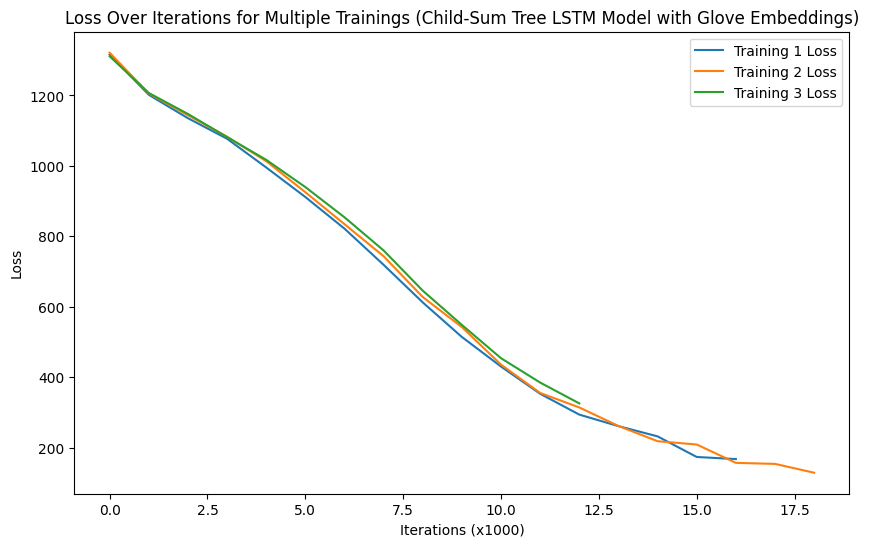

Average Test Accuracy: 0.4656
Test Accuracy Standard Deviation: 0.0087


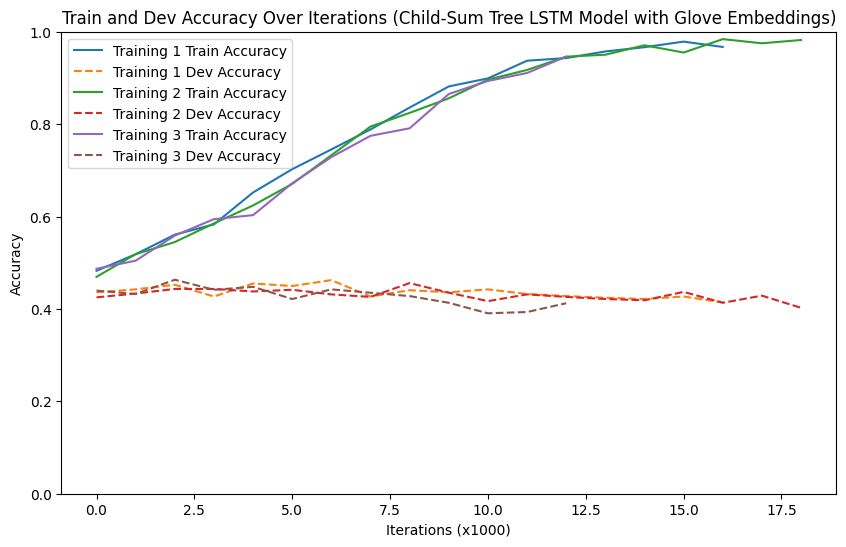

In [130]:
# Aggregate and display results

for i, result in enumerate(results["childsumtreelstm_glove"]):
    print(f"Training {i+1}:")
    print(f"  Final Test Loss: {result['test_loss']:.4f}")
    print(f"  Final Test Accuracy: {result['test_acc']:.4f}")

# Print average test loss
test_losses = [result["test_loss"] for result in results["childsumtreelstm_glove"]]
print(f"Average Test Loss: {np.mean(test_losses):.4f}")

# Print standard deviation of test loss
print(f"Test Loss Standard Deviation: {np.std(test_losses):.4f}")

# Plot loss over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["childsumtreelstm_glove"]):
    plt.plot(result["train_loss"], label=f"Training {i+1} Loss")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Loss")
plt.title("Loss Over Iterations for Multiple Trainings (Child-Sum Tree LSTM Model with Glove Embeddings)")
plt.legend()
# Save plot
plt.savefig("plots/childsumtreelstm_glove_loss.png")
plt.show()

# Print average test accuracy
test_accs = [result["test_acc"] for result in results["childsumtreelstm_glove"]]
print(f"Average Test Accuracy: {np.mean(test_accs):.4f}")

# Print standard deviation of test accuracy
print(f"Test Accuracy Standard Deviation: {np.std(test_accs):.4f}")

# Plot accuracy over iterations for each training
plt.figure(figsize=(10, 6))
for i, result in enumerate(results["childsumtreelstm_glove"]):
    plt.plot(result["train_acc"], label=f"Training {i+1} Train Accuracy")
    plt.plot(result["dev_acc"], label=f"Training {i+1} Dev Accuracy", linestyle="--")

plt.xlabel("Iterations (x1000)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Train and Dev Accuracy Over Iterations (Child-Sum Tree LSTM Model with Glove Embeddings)")
plt.legend()
# Save plot
plt.savefig("plots/childsumtreelstm_glove_acc.png")
plt.show()

In [131]:
import pandas as pd
from IPython.display import display

# Convert results dictionary into a tabular format with only test metrics
rows = []
for model_name, iterations in results.items():
    for i, metrics in enumerate(iterations):
        row = {
            "Model": model_name,
            "Iteration": i + 1,
            "Test Loss": metrics["test_loss"],
            "Test Accuracy": metrics["test_acc"]
        }
        rows.append(row)

# Create a DataFrame
df = pd.DataFrame(rows)

# Display the DataFrame in a notebook
display(df)

# Save the DataFrame as a CSV file
df.to_csv("results.csv", index=False)

,Model,Iteration,Test Loss,Test Accuracy
0,bow_model,1,4965.220076,0.280543
1,bow_model,2,3486.438569,0.372851
2,bow_model,3,3503.533969,0.380543
3,cbow_model,1,4245.535458,0.371493
4,cbow_model,2,4392.334096,0.355656
5,cbow_model,3,4183.766230,0.360181
6,deep_cbow_model,1,3165.377428,0.368778
7,deep_cbow_model,2,3325.909303,0.387330
8,deep_cbow_model,3,3179.830504,0.382353
9,pt_glove_deep_cbow_model,1,2918.472853,0.410860


In [132]:
# Create a summary table for average and standard deviation of test metrics
summary_rows = []
for model_name, iterations in results.items():
    test_losses = [metrics["test_loss"] for metrics in iterations]
    test_accuracies = [metrics["test_acc"] for metrics in iterations]
    
    row = {
        "Model": model_name,
        "Avg Test Loss": round(sum(test_losses) / len(test_losses), 4),
        "Std Test Loss": round(pd.Series(test_losses).std(), 4),
        "Avg Test Accuracy": round(sum(test_accuracies) / len(test_accuracies), 4),
        "Std Test Accuracy": round(pd.Series(test_accuracies).std(), 4),
    }
    summary_rows.append(row)

# Create a DataFrame for the summary
summary_df = pd.DataFrame(summary_rows)

# Display the summary table
display(summary_df)

# Save the summary table to a CSV file
summary_df.to_csv("results_summary.csv", index=False)

,Model,Avg Test Loss,Std Test Loss,Avg Test Accuracy,Std Test Accuracy
0,bow_model,3985.0642,848.8829,0.3446,0.0556
1,cbow_model,4273.8786,107.1337,0.3624,0.0082
2,deep_cbow_model,3223.7057,88.8054,0.3795,0.0096
3,pt_glove_deep_cbow_model,2927.2123,23.6517,0.4183,0.0098
4,pt_word2vec_deep_cbow_model,2890.0174,61.5718,0.4321,0.0096
5,lstm_glove,2647.8802,23.4715,0.4751,0.0063
6,lstm_glove_mb,173.9114,8.9448,0.4649,0.0030
7,lstm_glove_ft,248.4139,124.7511,0.4275,0.0144
8,treelstm_glove,164.9593,1.6366,0.4801,0.0036
9,childsumtreelstm_glove,199.3607,30.2456,0.4656,0.0107


# Further experiments and report

For your report, you are expected to answer research questions by doing further experiments.

## Research Questions

Make sure you cover at least the following:

- How important is word order for this task?
- Does the tree structure help to get a better accuracy?
- How does performance depend on the sentence length? Compare the various models. Is there a model that does better on longer sentences? If so, why?
- Do you get better performance if you supervise the sentiment **at each node in the tree**? You can extract more training examples by treating every node in each tree as a separate tree. You will need to write a function that extracts all subtrees given a treestring.
    - Warning: NLTK's Tree function seems to result in invalid trees in some cases, so be careful if you want to parse the string to a tree structure before extraction the phrases.

**To be able to obtain a full grade (10), you should conduct further investigations.** For example, you can also investigate one the following:

- When making a wrong prediction, can you figure out at what point in the tree (sentence) the model fails? You can make a prediction at each node to investigate.
- How does N-ary Tree LSTM compare to the Child-Sum Tree LSTM?
- How do the Tai et al. Tree LSTMs compare to Le & Zuidema's formulation?
- Or... your own research question!

These examples should give you an idea of the expected scope of your further investigations. The maximum number of points awarded for these further investigations depends on the depth of your analysis, and can also be awarded for one of the further research questions already listed above.

In general:

- ***When you report numbers, please report the mean accuracy across 3 (or more) runs with different random seed, together with the standard deviation.*** This is because the final performance may vary per random seed.
More precisely, you should run each model with 3 different seeds, and for each of these 3 runs, evaluate the best model (according to the validation) on the test dataset. The validation dataset is used for finding the best model over iterations, but the accuracy you report should be on the test dataset.

## Report instructions

Your report needs to be written in LaTeX. You are required to use the ACL 2023 template which you can download from or edit directly on [Overleaf](https://www.overleaf.com/latex/templates/acl-2023-proceedings-template/qjdgcrdwcnwp). Make sure your names and student numbers are visible at the top. (Tip: you need to uncomment `\aclfinalcopy`).
You can find some general tips about writing a research paper [here](https://www.microsoft.com/en-us/research/academic-program/write-great-research-paper/), but note that you need to make your own judgment about what is appropriate for this project.

We expect you to use the following structure:
1. Introduction (~1 page) - describe the problem, your research questions and goals, a summary of your findings and contributions. Please cite related work (models, data set) as part of your introduction here, since this is a short paper.
    - Introduce the task and the main goal
    - Present your research questions
    - Motivate the importance of the questions
    - Present and explain your expectations
    - Make clear whether the research questions are addressed or not addressed in the literature
    - Describe the approach you use to answer the research questions
    - Summarise your findings
2. Background (~1/2-1 page) -
cover the main techniques ("building blocks") used in your project (e.g. word embeddings, LSTM, Tree-LSTM) and intuitions behind them. Be accurate and concise.
    - How does each technique work? (Don't just copy the formulas)
    - What is the relation between the techniques?
3. Models (~1/2 page) - Describe the architecture of the final models.
    - How do you use LSTM or Tree-LSTM for the sentiment classification task?
    - What layers do you have, how do you do classification?
    - What is your loss function?
    - Etc.
4. Experiments (~1/2 page) - Describe your experimental setup. This section should allow someone else to reproduce your experiments. Describe how you evaluate the models.
    - Task and the data
    - Training (model, data, parameters and hyper parameters, training algorithms, supervision signals, etc.)
    - Evaluation (e.g. metrics)
5. Results and Analysis (~1 page). Present the results and analyse your findings.
    - Answer each of the research questions you raised in the introduction.
    - Use figures and tables to highlight interesting patterns
    - What are the factors that make model A better than model B in task C? Investigate to prove their effect!
6. Conclusion (~1/4 page). Present the conclusions that can be drawn from your experiments.
    - What have you learned from you experiments?
    - How do your findings relate to what is already known in the literature?
    - Were the results as expected? Any surprising results? Why?
    - Based on what you learned, what would you suggest doing next?


General Tips:

- Math notation – define each variable (either in running text, or in a pseudo-legenda after or before the equation).
- Define technical terminology you need.
- Avoid colloquial language – everything can be said in a scientific-sounding way.
- Avoid lengthy sentences, stay to the point.
- Do not spend space on "obvious" things.
- Do not go over the page limit. (We will deduct points for that.)
- The page limit is 4 pages excluding references and appendix. This is a strict limit; points will be deducted for longer reports.
- There is no strict limit to references and appendix. However, the report needs to remain fully self-contained: the appendix should only include content that is not necessary to understand your work. For example, preprocessing decisions, model parameters, pseudocode, sample system inputs/outputs, and other details that are necessary for the exact replication of your work can be put into the appendix.


An ideal report:
- Precise, scientific, technical, to the point
  - Little general “waffle”/chit-chat
- Not boring – because you don’t explain obvious things too much
- Efficient delivery of (only) the facts that we need to know to understand/reimplement
- Results visually well-presented and described with the correct priority of importance of sub-results
- Insightful analysis – speculation should connect to something interesting and not be too much; the reader “learns something new”
- No typos, no colloquialisms – well-considered language
- This normally means several re-draftings (re-orderings of information)
